# Centile subplots - dMRI data UKB

In [1]:
import os
os.chdir('/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/braincharts/scripts/')

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import matplotlib.colors
import seaborn as sns
import sys
from random import sample

from pcntoolkit.normative import estimate, predict, evaluate
from pcntoolkit.util.utils import compute_MSLL, create_design_matrix
from nm_utils import calibration_descriptives, remove_bad_subjects, load_2d

ukb_root = '/project_freenas/3022017.02/UKB'
sys.path.append(os.path.join(ukb_root,'scripts'))
from ukb_utils import get_variables_UKB, lookup_UKB
ukb_idp_dir = os.path.join(ukb_root,'phenotypes','current')
root_dir = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/braincharts'

#### Load data

In [2]:
# load sex
field_codes = ['eid','31-0.0']
field_names = ['eid', 'sex']
df_sex, subs = get_variables_UKB(os.path.join(ukb_idp_dir,'01_basic_demographics.csv'), field_codes, field_names)

# load age and site
field_codes = ['eid', '21003-2.0', '54-2.0']
field_names = ['eid', 'age', 'site']
df_age, subs = get_variables_UKB(os.path.join(ukb_idp_dir,'99_miscellaneous.csv'), field_codes, field_names)

# load dMRI derived phenotypes
field_codes = ['eid', 
               '25059-2.0', 
               '25101-2.0',
               '25100-2.0', 
               '25061-2.0',
               '25063-2.0', 
               '25062-2.0',
               '25107-2.0', 
               '25149-2.0',
               '25148-2.0', 
               '25109-2.0',
               '25111-2.0',
               '25347-2.0', 
               '25389-2.0',
               '25388-2.0', 
               '25349-2.0',
               '25351-2.0', 
               '25350-2.0',
               '25443-2.0', 
               '25485-2.0',
               '25484-2.0', 
               '25445-2.0',
               '25447-2.0', 
               '25446-2.0',]
field_names = ['eid', 
               'Mean_FA_in_body_of_corpus_callosum_on_FA_skeleton', 
               'Mean_FA _in_uncinate_fasciculus_on_FA_skeleton_left',
               'Mean_FA_in_uncinate_fasciculus_on_FA_skeleton_right',
               'Mean_FA_in_fornix_on_FA_skeleton',
               'Mean_FA_in_corticospinal_tract_on_FA_skeleton_left',
               'Mean_FA_in_corticospinal_tract_on_FA_skeleton_right',
               'Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton', 
               'Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_left',
               'Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_right',
               'Mean_MD_in_fornix_on_FA_skeleton',
               'Mean_MD_in_corticospinal_tract_on_FA_skeleton_left',              
               'Mean_ICVF_in_body_of_corpus_callosum_on_FA_skeleton', 
               'Mean_ICVF _in_uncinate_fasciculus_on_FA_skeleton_left',
               'Mean_ICVF_in_uncinate_fasciculus_on_FA_skeleton_right',
               'Mean_ICVF_in_fornix_on_FA_skeleton',
               'Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_left',
               'Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_right',
               'Mean_ISOVF_in_body_of_corpus_callosum_on_FA_skeleton', 
               'Mean_ISOVF _in_uncinate_fasciculus_on_FA_skeleton_left',
               'Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_right',
               'Mean_ISOVF_in_fornix_on_FA_skeleton',
               'Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_left',
               'Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_right']
# field_codes = ['eid','25107-2.0']
# field_names = ['eid', 'Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton']
df_dmri, subs = get_variables_UKB(os.path.join(ukb_idp_dir,'31_brain_IDPs.csv'), field_codes, field_names)

In [3]:
# fix small values to prevent error in the normative model estimation
dmri_data1 = df_sex.join(df_age).join(df_dmri)
dmri_data1.Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton = dmri_data1.Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton*1000
dmri_data1.Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_left = dmri_data1.Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_left*1000
dmri_data1.Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_right = dmri_data1.Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_right*1000
dmri_data1.Mean_MD_in_fornix_on_FA_skeleton = dmri_data1.Mean_MD_in_fornix_on_FA_skeleton*1000
dmri_data1.Mean_MD_in_corticospinal_tract_on_FA_skeleton_left = dmri_data1.Mean_MD_in_corticospinal_tract_on_FA_skeleton_left*1000
dmri_data1.dropna(inplace=True)
dmri_data1.to_csv(os.path.join(root_dir,'data1_dmri.csv'))

In [4]:
# 500 labeled sample
script_dir = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm'
pickled_data = os.path.join(script_dir,'500ukb_qcfeatures.pkl')
with open(pickled_data, 'rb') as f: 
    qc500_features = pickle.load(f)
qc500_path = '/home/preclineu/ramcir/Desktop/Diffusion/qc/dMRI/QC_500.csv'
qc500_labels = pd.read_csv(qc500_path)
qc500_labels["Score"] = [0 if ele > 2 else 1 for ele in qc500_labels["Score"]] # replace 3 scores with 0 and 2's with 1's
qc500_labels = qc500_labels.fillna(1) #replace nans with 1s
# Select the covariates and IDPs for the 500 subjects with labels
df_500sample = dmri_data1[dmri_data1.index.isin(qc500_labels.ID.astype(str))]

In [5]:
# where the raw data are stored
data_dir = os.path.join(root_dir,'data')

# where the analysis takes place
out_dir = os.path.join(root_dir,'models','test')

# create the output directory if it does not already exist
os.makedirs(out_dir, exist_ok=True)

### Split data

In [6]:
### Load all the subject IDs that have qc data available
pickled_data = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/subjects_qc.pkl'
with open(pickled_data, 'rb') as f: 
    subs_qc = pickle.load(f)
### Load the subjects IDs that have manual qc labels available 
pickled_data = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/labeledsubs_qc.pkl'
with open(pickled_data, 'rb') as f: 
    labeled_qc = pickle.load(f)
### Subtract the labeled subs from the total subs
keys = list(labeled_qc.columns.values)
i1 = subs_qc.set_index(keys).index
i2 = labeled_qc.set_index(keys).index
unlabeled_subs = subs_qc[~i1.isin(i2)]
print('There are', len(subs_qc), 'subjects in total')
print('There are', len(unlabeled_subs), 'subjects without manually assigned labels')
pickled_data2 = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/subs_test_5k.pkl'
with open(pickled_data2, 'rb') as f: 
    subs_test = pickle.load(f)
### Create the training subs list
keys = list(subs_test.columns.values)
i1 = unlabeled_subs.set_index(keys).index
i2 = subs_test.set_index(keys).index
subs_train = unlabeled_subs[~i1.isin(i2)]
print('There are', len(subs_train), 'subjects for training')
print('There are', len(subs_test), 'subjects for testing')
# subs_train.to_pickle('/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/subs_train_5k.pkl')

There are 23158 subjects in total
There are 22658 subjects without manually assigned labels
There are 17658 subjects for training
There are 5000 subjects for testing


In [7]:
### Create the training and testig dataset based on the subject lists
df_tr = dmri_data1[dmri_data1.index.isin(subs_train.subs)]
df_te = df_500sample
# df_te = dmri_data1[dmri_data1.index.isin(subs_test.subs)]

### Configure models

In [9]:
# with open(os.path.join(root_dir,'data','phenotypes.txt')) as f:
#     idp_ids = f.read().splitlines()
idp_ids = ['Mean_FA_in_body_of_corpus_callosum_on_FA_skeleton', 
               'Mean_FA _in_uncinate_fasciculus_on_FA_skeleton_left',
               'Mean_FA_in_uncinate_fasciculus_on_FA_skeleton_right',
               'Mean_FA_in_fornix_on_FA_skeleton',
               'Mean_FA_in_corticospinal_tract_on_FA_skeleton_left',
               'Mean_FA_in_corticospinal_tract_on_FA_skeleton_right',
               'Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton', 
               'Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_left',
               'Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_right',
               'Mean_MD_in_fornix_on_FA_skeleton',
               'Mean_MD_in_corticospinal_tract_on_FA_skeleton_left',               
               'Mean_ICVF_in_body_of_corpus_callosum_on_FA_skeleton', 
               'Mean_ICVF _in_uncinate_fasciculus_on_FA_skeleton_left',
               'Mean_ICVF_in_uncinate_fasciculus_on_FA_skeleton_right',
               'Mean_ICVF_in_fornix_on_FA_skeleton',
               'Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_left',
               'Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_right',
               'Mean_ISOVF_in_body_of_corpus_callosum_on_FA_skeleton', 
               'Mean_ISOVF _in_uncinate_fasciculus_on_FA_skeleton_left',
               'Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_right',
               'Mean_ISOVF_in_fornix_on_FA_skeleton',
               'Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_left',
               'Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_right']
# idp_ids = ['Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton'] 
site_ids =  sorted(set(df_tr['site'].to_list()))

# which data columns do we wish to use as covariates? 
cols_cov = ['age','sex']

# which warping function to use? We can set this to None in order to fit a vanilla Gaussian noise model
warp =  'WarpSinArcsinh'

# limits for cubic B-spline basis 
xmin = 45 
xmax = 85

# Do we want to force the model to be refit every time? 
force_refit = True

# Absolute Z treshold above which a sample is considered to be an outlier (without fitting any model)
outlier_thresh = 100

### Fit the model

In [10]:
for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
   
    # set output dir 
    idp_dir = os.path.join(out_dir, idp)
    os.makedirs(os.path.join(idp_dir), exist_ok=True)
    os.chdir(idp_dir)
    
    # extract the response variables for training and test set
    y_tr = df_tr[idp].to_numpy() 
    y_te = df_te[idp].to_numpy()
    
    
    hyp0 = np.zeros(4)
    
    
    # write out the response variables for training and test
    resp_file_tr = os.path.join(idp_dir, 'resp_tr.txt')
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_tr, y_tr)
    np.savetxt(resp_file_te, y_te)
        
    # configure the design matrix
    X_tr = create_design_matrix(df_tr[cols_cov], 
                                xmin = xmin, 
                                xmax = xmax)
    X_te = create_design_matrix(df_te[cols_cov], 
                                basis = 'bspline', 
                                xmin = xmin, 
                                xmax = xmax)

    # configure and save the covariates
    cov_file_tr = os.path.join(idp_dir, 'cov_bspline_tr.txt')
    cov_file_te = os.path.join(idp_dir, 'cov_bspline_te.txt')
    np.savetxt(cov_file_tr, X_tr)
    np.savetxt(cov_file_te, X_te)

    if not force_refit and os.path.exists(os.path.join(idp_dir, 'Models', 'NM_0_0_estimate.pkl')):
        print('Making predictions using a pre-existing model...')
        suffix = 'predict'
        
        # Make prdictsion with test data
        predict(cov_file_te, 
                alg='blr', 
                respfile=resp_file_te, 
                model_path=os.path.join(idp_dir,'Models'),
                outputsuffix=suffix)
    else:
        print('Estimating the normative model...')
        estimate(cov_file_tr, resp_file_tr, testresp=resp_file_te, 
                 testcov=cov_file_te, alg='blr', optimizer = 'l-bfgs-b', l=1000,
                 savemodel=True, warp=warp, warp_reparam=True)
        suffix = 'estimate'

Running IDP 0 Mean_FA_in_body_of_corpus_callosum_on_FA_skeleton :
Estimating the normative model...
Processing data in /home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/braincharts/models/test/Mean_FA_in_body_of_corpus_callosum_on_FA_skeleton/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 1 Mean_FA _in_uncinate_fasciculus_on_FA_skeleton_left :
Estimating the normative model...
Processing data in /home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/braincharts/models/test/Mean_FA _in_uncinate_fasciculus_on_FA_skeleton_left/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 2 Mean_FA_in_uncinate_fasciculus_on_FA_skeleton_right :
Estimating the normative model...
Processing data in /home/preclineu/ramcir/Desktop/Diffusion/diffusio

/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.92621e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.38679e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.24584e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=6.55053e-17): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/precli

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 12 Mean_ICVF _in_uncinate_fasciculus_on_FA_skeleton_left :
Estimating the normative model...
Processing data in /home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/braincharts/models/test/Mean_ICVF _in_uncinate_fasciculus_on_FA_skeleton_left/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 13 Mean_ICVF_in_uncinate_fasciculus_on_FA_skeleton_right :
Estimating the normative model...
Processing data in /home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/braincharts/models/test/Mean_ICVF_in_uncinate_fasciculus_on_FA_skeleton_right/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 14 Mean_ICVF_in_fornix_on_FA_skeleton :
Estimating the normative model...

/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.54956e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.78923e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.68788e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.60652e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/precli

/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.82784e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=5.73345e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.68939e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=3.82551e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 18 Mean_ISOVF _in_uncinate_fasciculus_on_FA_skeleton_left :
Estimating the normative model...
Processing data in /home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/braincharts/models/test/Mean_ISOVF _in_uncinate_fasciculus_on_FA_skeleton_left/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.40233e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.31426e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=7.40854e-21): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.38598e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/precli

Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 19 Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_right :
Estimating the normative model...
Processing data in /home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/braincharts/models/test/Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_right/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters


/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.86717e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.43883e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=1.62034e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)
/home/preclineu/ramcir/.conda/envs/myenv/lib/python3.8/site-packages/pcntoolkit/model/bayesreg.py:187: LinAlgWarning: Ill-conditioned matrix (rcond=2.8465e-20): result may not be accurate.
  invAXt = linalg.solve(self.A, X.T, check_finite=False)


Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 20 Mean_ISOVF_in_fornix_on_FA_skeleton :
Estimating the normative model...
Processing data in /home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/braincharts/models/test/Mean_ISOVF_in_fornix_on_FA_skeleton/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 21 Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_left :
Estimating the normative model...
Processing data in /home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/braincharts/models/test/Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_left/resp_tr.txt
Estimating model  1 of 1
configuring BLR ( order 1 )
Using default hyperparameters
Saving model meta-data...
Evaluating the model ...
Writing outputs ...
Running IDP 22 Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_right :
Estimating the normative model...
Processing data

In [11]:
# initialise dataframe we will use to store quantitative metrics 
blr_metrics = pd.DataFrame(columns = ['eid', 'NLL', 'EV', 'MSLL', 'BIC','Skew','Kurtosis'])

for idp_num, idp in enumerate(idp_ids): 
    idp_dir = os.path.join(out_dir, idp)
    
    # load the predictions and true data. We use a custom function that ensures 2d arrays
    # equivalent to: y = np.loadtxt(filename); y = y[:, np.newaxis]
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_' + suffix + '.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_' + suffix + '.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))
    
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
    # compute error metrics
    if warp is None:
        metrics = evaluate(y_te, yhat_te)  
        
        # compute MSLL manually as a sanity check
        y_tr_mean = np.array( [[np.mean(y_tr)]] )
        y_tr_var = np.array( [[np.var(y_tr)]] )
        MSLL = compute_MSLL(y_te, yhat_te, s2_te, y_tr_mean, y_tr_var)         
    else:
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        W = nm.blr.warp
        
        # warp predictions
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
       
        # evaluation metrics
        metrics = evaluate(y_te, med_te)
        
        # compute MSLL manually
        y_te_w = W.f(y_te, warp_param)
        y_tr_w = W.f(y_tr, warp_param)
        y_tr_mean = np.array( [[np.mean(y_tr_w)]] )
        y_tr_var = np.array( [[np.var(y_tr_w)]] )
        MSLL = compute_MSLL(y_te_w, yhat_te, s2_te, y_tr_mean, y_tr_var)     
    
    Z = np.loadtxt(os.path.join(idp_dir, 'Z_' + suffix + '.txt'))
    [skew, sdskew, kurtosis, sdkurtosis, semean, sesd] = calibration_descriptives(Z)
    
    BIC = len(nm.blr.hyp) * np.log(y_tr.shape[0]) + 2 * nm.neg_log_lik
    
    blr_metrics.loc[len(blr_metrics)] = [idp, nm.neg_log_lik, metrics['EXPV'][0], 
                                         MSLL[0], BIC, skew, kurtosis]
    
display(blr_metrics)

blr_metrics.to_pickle(os.path.join(out_dir,'blr_metrics.pkl'))

eid           NLL        EV  \
0   Mean_FA_in_body_of_corpus_callosum_on_FA_skeleton -34704.462862  0.101537   
1   Mean_FA _in_uncinate_fasciculus_on_FA_skeleton... -28834.048991  0.038952   
2   Mean_FA_in_uncinate_fasciculus_on_FA_skeleton_... -29501.134074  0.019954   
3                    Mean_FA_in_fornix_on_FA_skeleton -17525.233566  0.259303   
4   Mean_FA_in_corticospinal_tract_on_FA_skeleton_... -31512.288078  0.065884   
5   Mean_FA_in_corticospinal_tract_on_FA_skeleton_... -29982.935582  0.093453   
6   Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton -30217.931439  0.199060   
7   Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_... -30281.256491  0.092207   
8   Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_... -32569.814149  0.103020   
9                    Mean_MD_in_fornix_on_FA_skeleton   4851.068153  0.244423   
10  Mean_MD_in_corticospinal_tract_on_FA_skeleton_... -18196.157297  0.007676   
11  Mean_ICVF_in_body_of_corpus_callosum_on_FA_ske... -30839.141586  0.020120   
12  Mean_ICVF _in_uncinate_fasciculus_on_FA_skelet... -30574.998781  0.106161   
13  Mean_ICVF_in_uncinate_fasciculus_on_FA_skeleto... -30907.961085  0.099743   
14                 Mean_ICVF_in_fornix_on_FA_skeleton -19447.509530  0.049455   
15  Mean_ICVF_in_corticospinal_tract_on_FA_skeleto... -26861.990780  0.029339   
16  Mean_ICVF_in_corticospinal_tract_on_FA_skeleto... -26399.386510  0.040858   
17  Mean_ISOVF_in_body_of_corpus_callosum_on_FA_sk... -37913.368893  0.230523   
18  Mean_ISOVF _in_uncinate_fasciculus_on_FA_skele... -27612.898448  0.024638   
19  Mean_ISOVF_in_uncinate_fasciculus_on_FA_skelet... -41930.475759  0.040854   
20                Mean_ISOVF_in_fornix_on_FA_skeleton  -9505.365457  0.296941   
21  Mean_ISOVF_in_corticospinal_tract_on_FA_skelet... -22223.314585  0.004380   
22  Mean_ISOVF_in_corticospinal_tract_on_FA_skelet... -20117.265721  0.010126   

          MSLL           BIC      Skew   Kurtosis  
0  -105.959250 -69369.810400 -0.308128   0.281445  
1   -30.760415 -57628.982658 -0.040801   0.458719  
2   -34.246384 -58963.152825 -0.154580   0.291619  
3   -15.798273 -35011.351808 -0.443655   0.392525  
4   -37.573740 -62985.460833 -0.280212   0.217317  
5   -32.497876 -59926.755841 -0.159463  -0.037447  
6  -183.513629 -60396.747553  0.774209   1.415736  
7  -129.024090 -60523.397657  0.946720   4.500896  
8  -145.968181 -65100.512974  0.302973   1.408972  
9  -986.617614   9741.251630  1.515651   3.233599  
10 -153.213687 -36353.199270  0.964560   1.555828  
11  -77.371185 -61639.167849 -0.329712   0.001945  
12  -30.288821 -61110.882239  0.122856   0.206442  
13  -29.536582 -61776.806847  0.392496   0.827920  
14  -42.611724 -38855.903737  0.036848   0.047060  
15 -109.845115 -53684.866237 -0.138368   0.275962  
16 -112.566219 -52759.657697 -0.138868   0.300944  
17   -1.103487 -75787.622463  0.752912   2.182724  
18   -3.140616 -55186.681573  2.602342  14.866605  
19   -4.284280 -83821.836194  1.652921   5.604670  
20  -45.676689 -18971.615589  0.707891   0.579563  
21   -0.025607 -44407.513847  1.090687   2.485373  
22    0.004302 -40195.416118  1.307555   3.603144

### Make predictions

In [12]:
for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)
    
    # extract and save the response variables for the test set
    y_te = df_te[idp].to_numpy()
    y_tr = df_tr[idp].to_numpy()
    
    # save the variables
    resp_file_te = os.path.join(idp_dir, 'resp_te.txt') 
    np.savetxt(resp_file_te, y_te)
    
    resp_file_tr = os.path.join(idp_dir, 'resp_tr.txt') 
    np.savetxt(resp_file_tr, y_tr)
    
    yhat_te, s2_te, Z = predict(cov_file_te, 
                                    alg='blr', 
                                    respfile=resp_file_te, 
                                    model_path=os.path.join(idp_dir,'Models'))

Running IDP 0 Mean_FA_in_body_of_corpus_callosum_on_FA_skeleton :
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 1 Mean_FA _in_uncinate_fasciculus_on_FA_skeleton_left :
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 2 Mean_FA_in_uncinate_fasciculus_on_FA_skeleton_right :
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 3 Mean_FA_in_fornix_on_FA_skeleton :
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 4 Mean_FA_in_corticospinal_tract_on_FA_skeleton_left :
Loading data ...
Prediction by model  1 of 1
Evaluating the model ...
Evaluations Writing outputs ...
Writing outputs ...
Running IDP 5 Mean_FA_in_corticospinal_tract_on_FA_skeleton_right :
Load

### Dummy data for plotting

In [13]:
# which sex do we want to plot? 
sex = 2 # 1 = male 0 = female
clr = 'grey'  
# create dummy data for visualisation
print('configuring dummy data ...')
xx = np.arange(xmin, xmax, 0.5)
X0_dummy = np.zeros((len(xx), 2))
X0_dummy[:,0] = xx
X0_dummy[:,1] = sex

# create the design matrix
X_dummy = create_design_matrix(X0_dummy, xmin=xmin, xmax=xmax)

# save the dummy covariates
cov_file_dummy = os.path.join(out_dir,'cov_bspline_dummy_mean.txt')
np.savetxt(cov_file_dummy, X_dummy)

configuring dummy data ...


Running IDP 0 Mean_FA_in_body_of_corpus_callosum_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0280353]), 'Rho': array([0.31882952]), 'pRho': array([1.77792156e-13]), 'SMSE': array([0.89998746]), 'EXPV': array([0.10153668])}


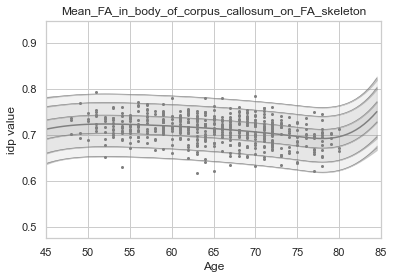

Running IDP 1 Mean_FA _in_uncinate_fasciculus_on_FA_skeleton_left :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0389807]), 'Rho': array([0.20285188]), 'pRho': array([4.52068033e-06]), 'SMSE': array([0.96106032]), 'EXPV': array([0.03895207])}


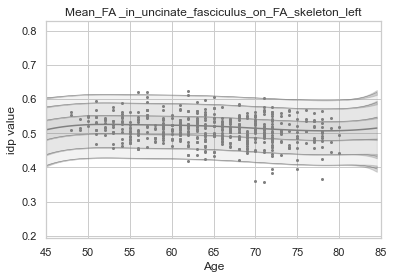

Running IDP 2 Mean_FA_in_uncinate_fasciculus_on_FA_skeleton_right :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0371995]), 'Rho': array([0.14243284]), 'pRho': array([0.00138834]), 'SMSE': array([0.98054281]), 'EXPV': array([0.01995417])}


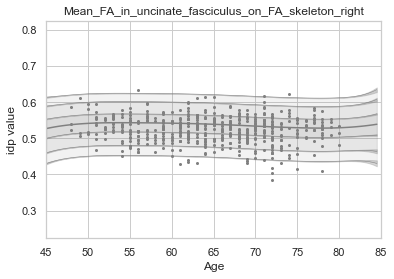

Running IDP 3 Mean_FA_in_fornix_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.07724096]), 'Rho': array([0.50963973]), 'pRho': array([4.84243756e-36]), 'SMSE': array([0.74293082]), 'EXPV': array([0.25930322])}


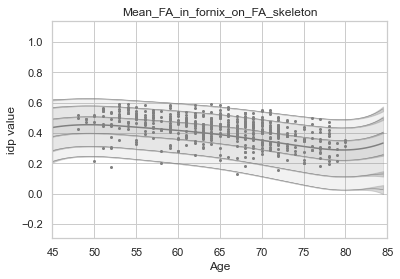

Running IDP 4 Mean_FA_in_corticospinal_tract_on_FA_skeleton_left :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03284036]), 'Rho': array([0.25667998]), 'pRho': array([4.82264845e-09]), 'SMSE': array([0.93414857]), 'EXPV': array([0.06588351])}


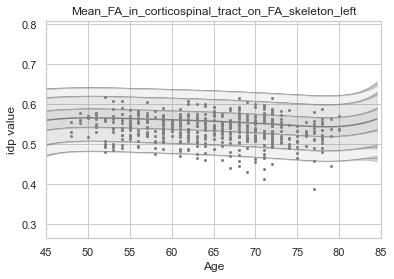

Running IDP 5 Mean_FA_in_corticospinal_tract_on_FA_skeleton_right :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03658059]), 'Rho': array([0.30579869]), 'pRho': array([1.88676252e-12]), 'SMSE': array([0.90687006]), 'EXPV': array([0.09345348])}


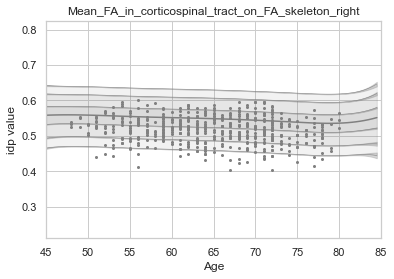

Running IDP 6 Mean_MD_in_body_of_corpus_callosum_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03500207]), 'Rho': array([0.4482454]), 'pRho': array([5.51298963e-27]), 'SMSE': array([0.80093989]), 'EXPV': array([0.19906041])}


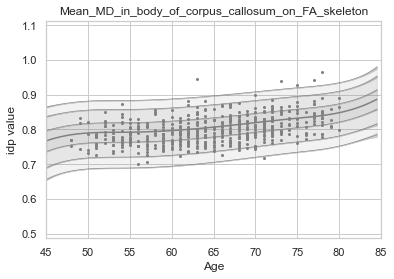

Running IDP 7 Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_left :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03591932]), 'Rho': array([0.30661639]), 'pRho': array([1.63271918e-12]), 'SMSE': array([0.913046]), 'EXPV': array([0.09220714])}


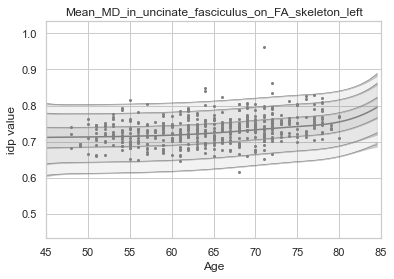

Running IDP 8 Mean_MD_in_uncinate_fasciculus_on_FA_skeleton_right :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03072455]), 'Rho': array([0.32231915]), 'pRho': array([9.24797135e-14]), 'SMSE': array([0.89698535]), 'EXPV': array([0.1030203])}


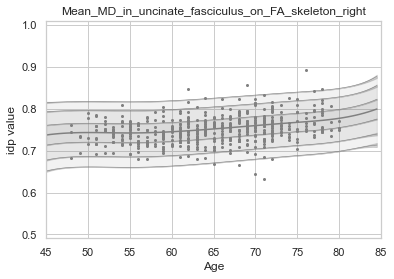

Running IDP 9 Mean_MD_in_fornix_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.28225453]), 'Rho': array([0.49524261]), 'pRho': array([9.93837089e-34]), 'SMSE': array([0.75593304]), 'EXPV': array([0.24442328])}


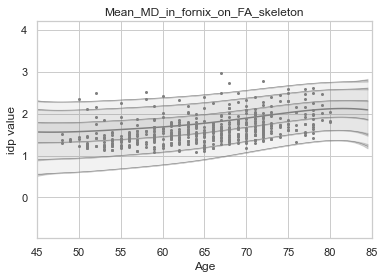

Running IDP 10 Mean_MD_in_corticospinal_tract_on_FA_skeleton_left :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06950976]), 'Rho': array([0.08953648]), 'pRho': array([0.04534487]), 'SMSE': array([1.00458896]), 'EXPV': array([0.00767647])}


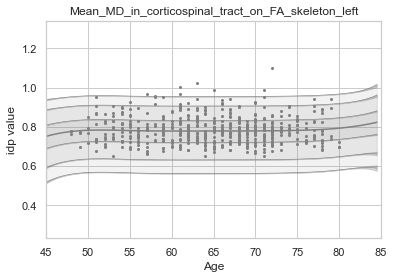

Running IDP 11 Mean_ICVF_in_body_of_corpus_callosum_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03282261]), 'Rho': array([0.15854729]), 'pRho': array([0.00036435]), 'SMSE': array([0.98132927]), 'EXPV': array([0.02011991])}


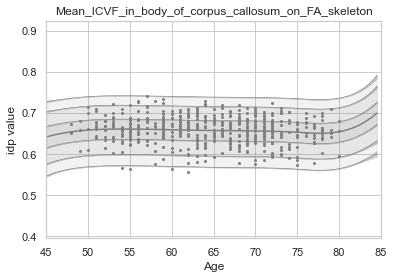

Running IDP 12 Mean_ICVF _in_uncinate_fasciculus_on_FA_skeleton_left :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0284036]), 'Rho': array([0.32788104]), 'pRho': array([3.20226695e-14]), 'SMSE': array([0.89608563]), 'EXPV': array([0.10616129])}


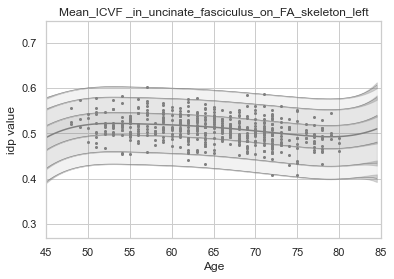

Running IDP 13 Mean_ICVF_in_uncinate_fasciculus_on_FA_skeleton_right :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02826456]), 'Rho': array([0.31697341]), 'pRho': array([2.50788283e-13]), 'SMSE': array([0.90272443]), 'EXPV': array([0.09974286])}


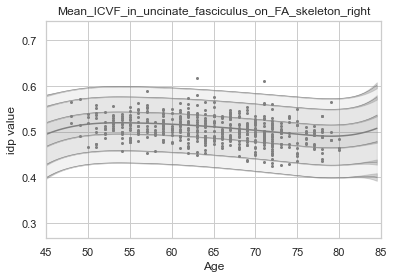

Running IDP 14 Mean_ICVF_in_fornix_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06665886]), 'Rho': array([0.2250944]), 'pRho': array([3.29803951e-07]), 'SMSE': array([0.95062275]), 'EXPV': array([0.04945492])}


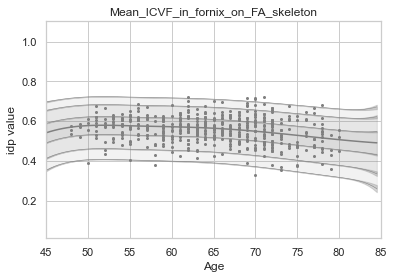

Running IDP 15 Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_left :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04336997]), 'Rho': array([0.17277269]), 'pRho': array([9.99415581e-05]), 'SMSE': array([0.97121457]), 'EXPV': array([0.02933893])}


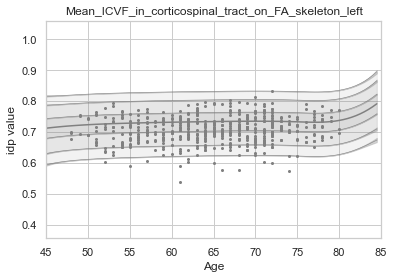

Running IDP 16 Mean_ICVF_in_corticospinal_tract_on_FA_skeleton_right :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0441188]), 'Rho': array([0.2030145]), 'pRho': array([4.43956738e-06]), 'SMSE': array([0.96073253]), 'EXPV': array([0.04085767])}


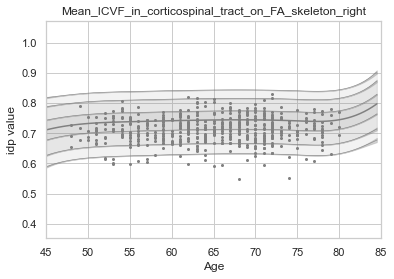

Running IDP 17 Mean_ISOVF_in_body_of_corpus_callosum_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01735565]), 'Rho': array([0.4811337]), 'pRho': array([1.40029263e-31]), 'SMSE': array([0.76974681]), 'EXPV': array([0.23052343])}


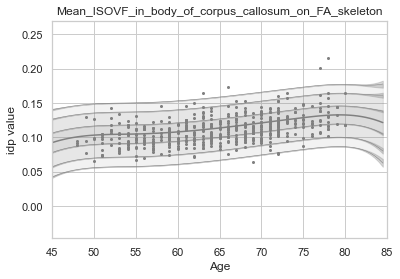

Running IDP 18 Mean_ISOVF _in_uncinate_fasciculus_on_FA_skeleton_left :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01364692]), 'Rho': array([0.16148432]), 'pRho': array([0.00028141]), 'SMSE': array([0.98162856]), 'EXPV': array([0.02463765])}


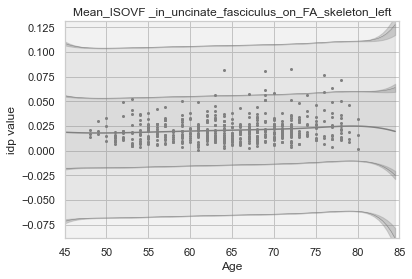

Running IDP 19 Mean_ISOVF_in_uncinate_fasciculus_on_FA_skeleton_right :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01188308]), 'Rho': array([0.20595452]), 'pRho': array([3.19188925e-06]), 'SMSE': array([0.95917302]), 'EXPV': array([0.04085387])}


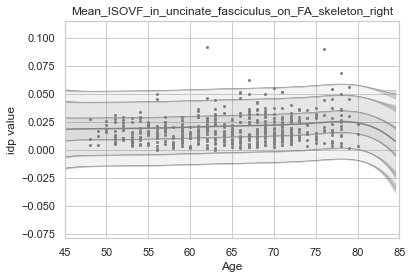

Running IDP 20 Mean_ISOVF_in_fornix_on_FA_skeleton :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11891982]), 'Rho': array([0.54529414]), 'pRho': array([2.44524208e-42]), 'SMSE': array([0.70364477]), 'EXPV': array([0.29694068])}


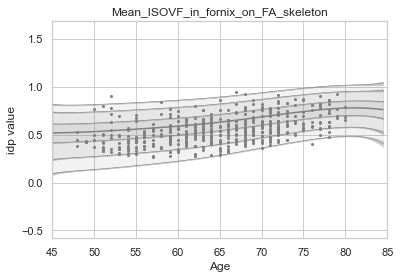

Running IDP 21 Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_left :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04591738]), 'Rho': array([0.06866227]), 'pRho': array([0.12524272]), 'SMSE': array([1.00767551]), 'EXPV': array([0.00437952])}


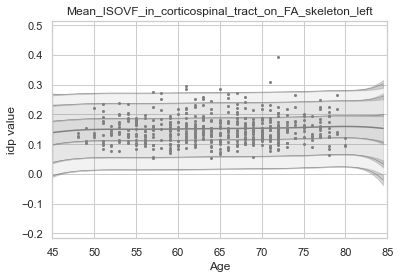

Running IDP 22 Mean_ISOVF_in_corticospinal_tract_on_FA_skeleton_right :
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.05486324]), 'Rho': array([0.11358418]), 'pRho': array([0.01098539]), 'SMSE': array([0.99337421]), 'EXPV': array([0.01012551])}


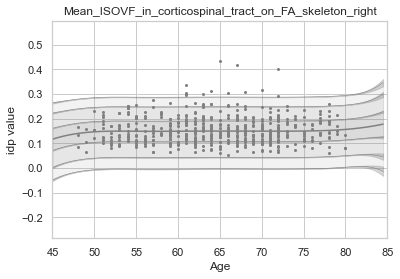

In [16]:
sns.set(style='whitegrid')

for idp_num, idp in enumerate(idp_ids): 
    print('Running IDP', idp_num, idp, ':')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)
    
    # load the true data points
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))
            
    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')
    
    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 
    
    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 
        
    # first, we warp predictions for the true data and compute evaluation metrics
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]
    print('metrics:', evaluate(y_te, med_te))
    
    # then, we warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)
    
    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)
    idx = range(0, len(X_te))
    # plot the (adjusted) data points
    plt.scatter(X_te[idx,1], y_te, s=4, color=clr, alpha = 1)
       
    # plot the median of the dummy data
    plt.plot(xx, med, clr)
    
    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)
            
    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)
    
    plt.xlabel('Age')
    plt.ylabel('idp value') 
    plt.title(idp)
    plt.xlim((45,85))
    plt.ylim((np.mean(y_te)-8*np.std(y_te)), (np.mean(y_te)+8*np.std(y_te)))
    plt.savefig(os.path.join(idp_dir, 'test_data'))
    plt.show()
    
os.chdir(out_dir)

### Subplots

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0280353]), 'Rho': array([0.31882952]), 'pRho': array([1.77792156e-13]), 'SMSE': array([0.89998746]), 'EXPV': array([0.10153668])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0280353]), 'Rho': array([0.31882952]), 'pRho': array([1.77792156e-13]), 'SMSE': array([0.89998746]), 'EXPV': array([0.10153668])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0280353]), 'Rho': array([0.31882952]), 'pRho': array([1.77792156e-13]), 'SMSE': array([0.89998746]), 'EXPV': array([0.10153668])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0280353]), 'Rho': array([0.31882952]), 'pRho': array([1.77792156e-13]), 'SMSE': array([0.89998746]), 'EXPV': array([0.10153668])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0280353]), 'Rho': array([0.31882952]), 'pRho': array([1.77792156e-13]), 'SMSE': array([0.89998746]), 'EXPV': array([0.10153668])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0280353]), 'Rho': array([0.31882952]), 'pRho': array([1.77792156e-13]), 'SMSE': array([0.89998746]), 'EXPV': array([0.10153668])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


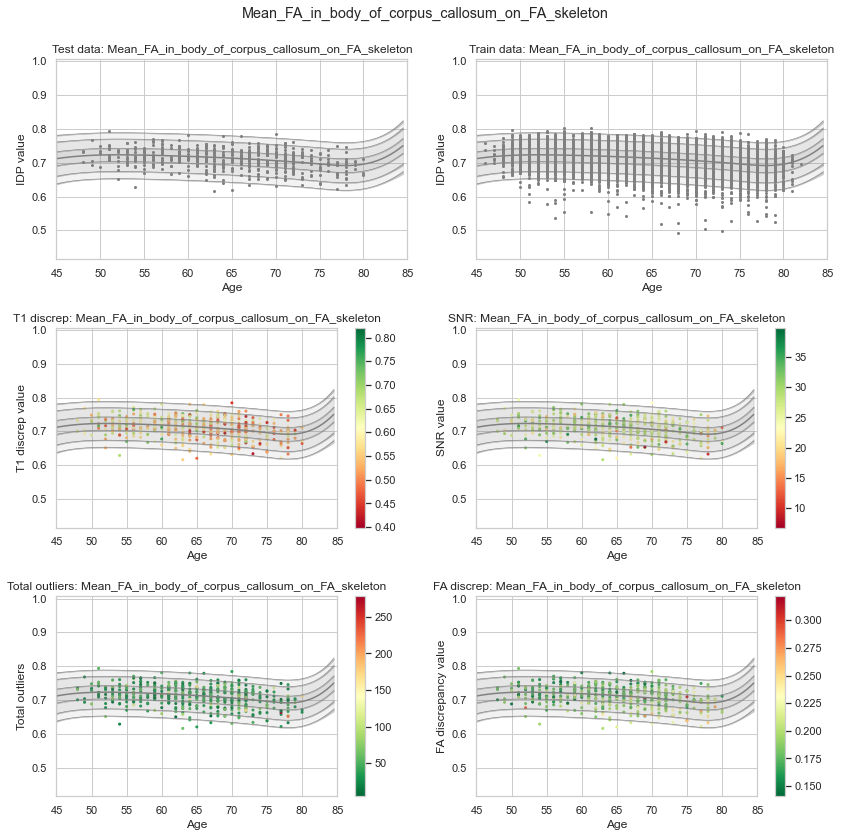

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0389807]), 'Rho': array([0.20285188]), 'pRho': array([4.52068033e-06]), 'SMSE': array([0.96106032]), 'EXPV': array([0.03895207])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0389807]), 'Rho': array([0.20285188]), 'pRho': array([4.52068033e-06]), 'SMSE': array([0.96106032]), 'EXPV': array([0.03895207])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0389807]), 'Rho': array([0.20285188]), 'pRho': array([4.52068033e-06]), 'SMSE': array([0.96106032]), 'EXPV': array([0.03895207])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0389807]), 'Rho': array([0.20285188]), 'pRho': array([4.52068033e-06]), 'SMSE': array([0.96106032]), 'EXPV': array([0.03895207])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0389807]), 'Rho': array([0.20285188]), 'pRho': array([4.52068033e-06]), 'SMSE': array([0.96106032]), 'EXPV': array([0.03895207])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0389807]), 'Rho': array([0.20285188]), 'pRho': array([4.52068033e-06]), 'SMSE': array([0.96106032]), 'EXPV': array([0.03895207])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


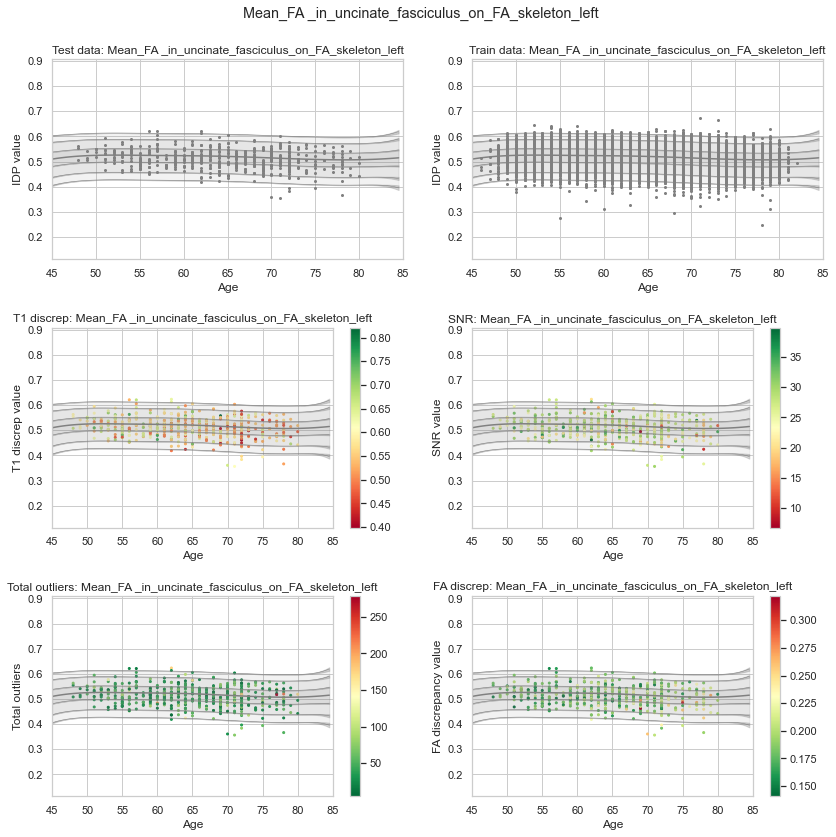

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0371995]), 'Rho': array([0.14243284]), 'pRho': array([0.00138834]), 'SMSE': array([0.98054281]), 'EXPV': array([0.01995417])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0371995]), 'Rho': array([0.14243284]), 'pRho': array([0.00138834]), 'SMSE': array([0.98054281]), 'EXPV': array([0.01995417])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0371995]), 'Rho': array([0.14243284]), 'pRho': array([0.00138834]), 'SMSE': array([0.98054281]), 'EXPV': array([0.01995417])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0371995]), 'Rho': array([0.14243284]), 'pRho': array([0.00138834]), 'SMSE': array([0.98054281]), 'EXPV': array([0.01995417])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0371995]), 'Rho': array([0.14243284]), 'pRho': array([0.00138834]), 'SMSE': array([0.98054281]), 'EXPV': array([0.01995417])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0371995]), 'Rho': array([0.14243284]), 'pRho': array([0.00138834]), 'SMSE': array([0.98054281]), 'EXPV': array([0.01995417])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


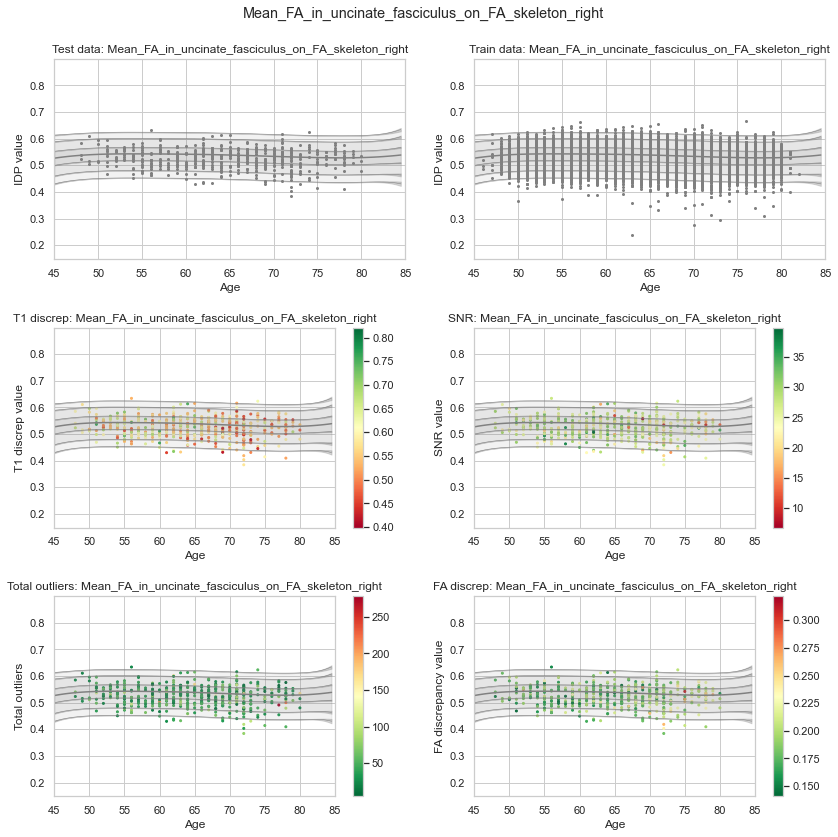

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.07724096]), 'Rho': array([0.50963973]), 'pRho': array([4.84243756e-36]), 'SMSE': array([0.74293082]), 'EXPV': array([0.25930322])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.07724096]), 'Rho': array([0.50963973]), 'pRho': array([4.84243756e-36]), 'SMSE': array([0.74293082]), 'EXPV': array([0.25930322])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.07724096]), 'Rho': array([0.50963973]), 'pRho': array([4.84243756e-36]), 'SMSE': array([0.74293082]), 'EXPV': array([0.25930322])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.07724096]), 'Rho': array([0.50963973]), 'pRho': array([4.84243756e-36]), 'SMSE': array([0.74293082]), 'EXPV': array([0.25930322])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.07724096]), 'Rho': array([0.50963973]), 'pRho': array([4.84243756e-36]), 'SMSE': array([0.74293082]), 'EXPV': array([0.25930322])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.07724096]), 'Rho': array([0.50963973]), 'pRho': array([4.84243756e-36]), 'SMSE': array([0.74293082]), 'EXPV': array([0.25930322])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


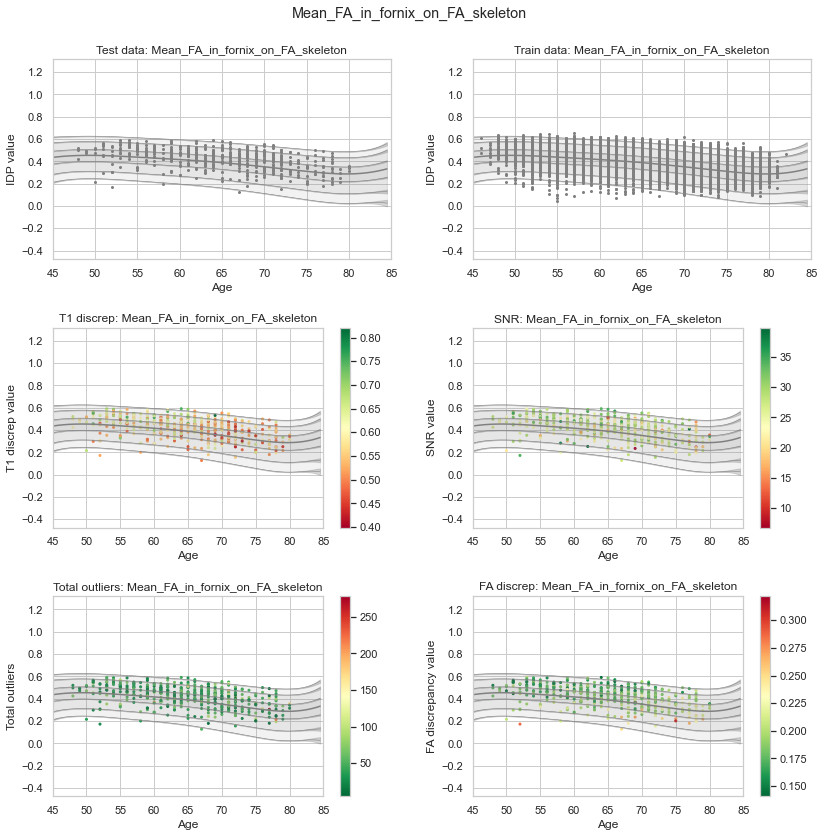

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03284036]), 'Rho': array([0.25667998]), 'pRho': array([4.82264845e-09]), 'SMSE': array([0.93414857]), 'EXPV': array([0.06588351])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03284036]), 'Rho': array([0.25667998]), 'pRho': array([4.82264845e-09]), 'SMSE': array([0.93414857]), 'EXPV': array([0.06588351])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03284036]), 'Rho': array([0.25667998]), 'pRho': array([4.82264845e-09]), 'SMSE': array([0.93414857]), 'EXPV': array([0.06588351])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03284036]), 'Rho': array([0.25667998]), 'pRho': array([4.82264845e-09]), 'SMSE': array([0.93414857]), 'EXPV': array([0.06588351])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03284036]), 'Rho': array([0.25667998]), 'pRho': array([4.82264845e-09]), 'SMSE': array([0.93414857]), 'EXPV': array([0.06588351])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03284036]), 'Rho': array([0.25667998]), 'pRho': array([4.82264845e-09]), 'SMSE': array([0.93414857]), 'EXPV': array([0.06588351])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


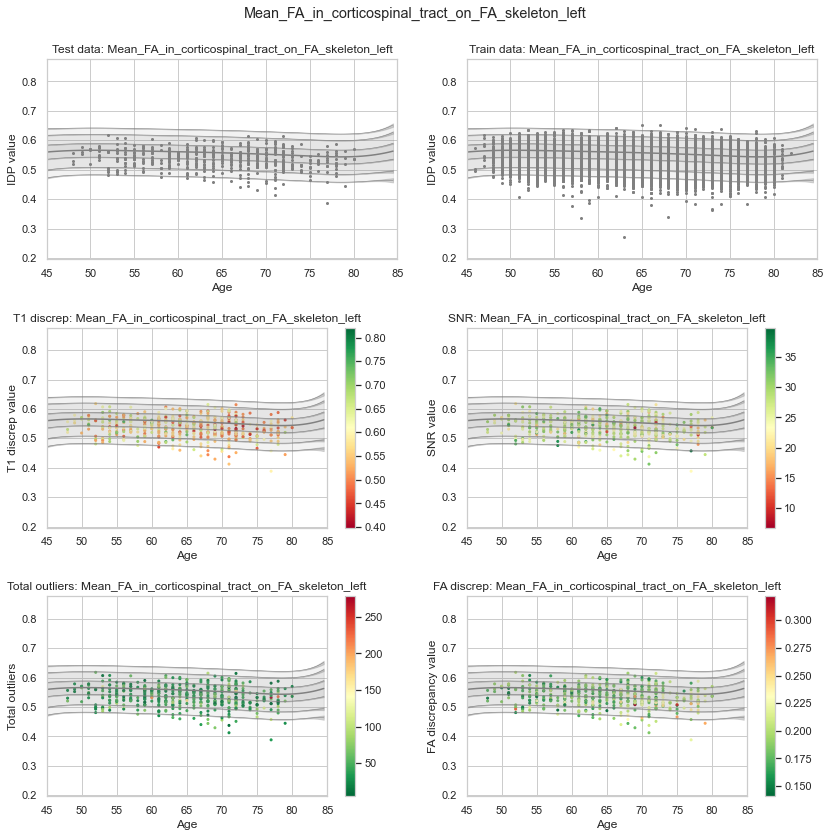

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03658059]), 'Rho': array([0.30579869]), 'pRho': array([1.88676252e-12]), 'SMSE': array([0.90687006]), 'EXPV': array([0.09345348])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03658059]), 'Rho': array([0.30579869]), 'pRho': array([1.88676252e-12]), 'SMSE': array([0.90687006]), 'EXPV': array([0.09345348])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03658059]), 'Rho': array([0.30579869]), 'pRho': array([1.88676252e-12]), 'SMSE': array([0.90687006]), 'EXPV': array([0.09345348])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03658059]), 'Rho': array([0.30579869]), 'pRho': array([1.88676252e-12]), 'SMSE': array([0.90687006]), 'EXPV': array([0.09345348])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03658059]), 'Rho': array([0.30579869]), 'pRho': array([1.88676252e-12]), 'SMSE': array([0.90687006]), 'EXPV': array([0.09345348])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03658059]), 'Rho': array([0.30579869]), 'pRho': array([1.88676252e-12]), 'SMSE': array([0.90687006]), 'EXPV': array([0.09345348])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


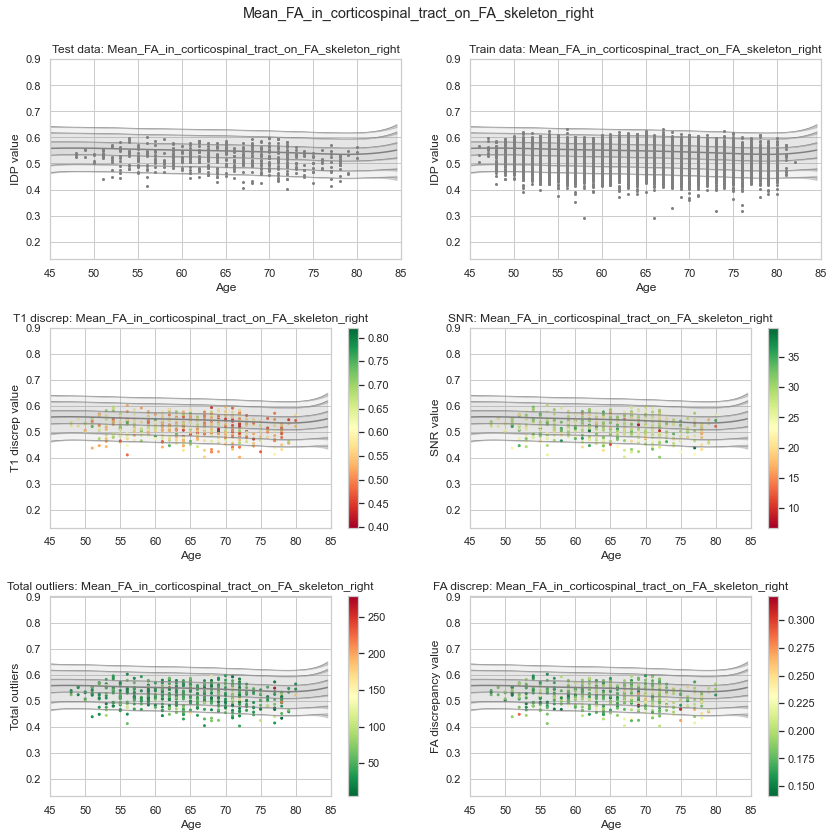

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03500207]), 'Rho': array([0.4482454]), 'pRho': array([5.51298963e-27]), 'SMSE': array([0.80093989]), 'EXPV': array([0.19906041])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03500207]), 'Rho': array([0.4482454]), 'pRho': array([5.51298963e-27]), 'SMSE': array([0.80093989]), 'EXPV': array([0.19906041])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03500207]), 'Rho': array([0.4482454]), 'pRho': array([5.51298963e-27]), 'SMSE': array([0.80093989]), 'EXPV': array([0.19906041])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03500207]), 'Rho': array([0.4482454]), 'pRho': array([5.51298963e-27]), 'SMSE': array([0.80093989]), 'EXPV': array([0.19906041])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03500207]), 'Rho': array([0.4482454]), 'pRho': array([5.51298963e-27]), 'SMSE': array([0.80093989]), 'EXPV': array([0.19906041])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03500207]), 'Rho': array([0.4482454]), 'pRho': array([5.51298963e-27]), 'SMSE': array([0.80093989]), 'EXPV': array([0.19906041])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


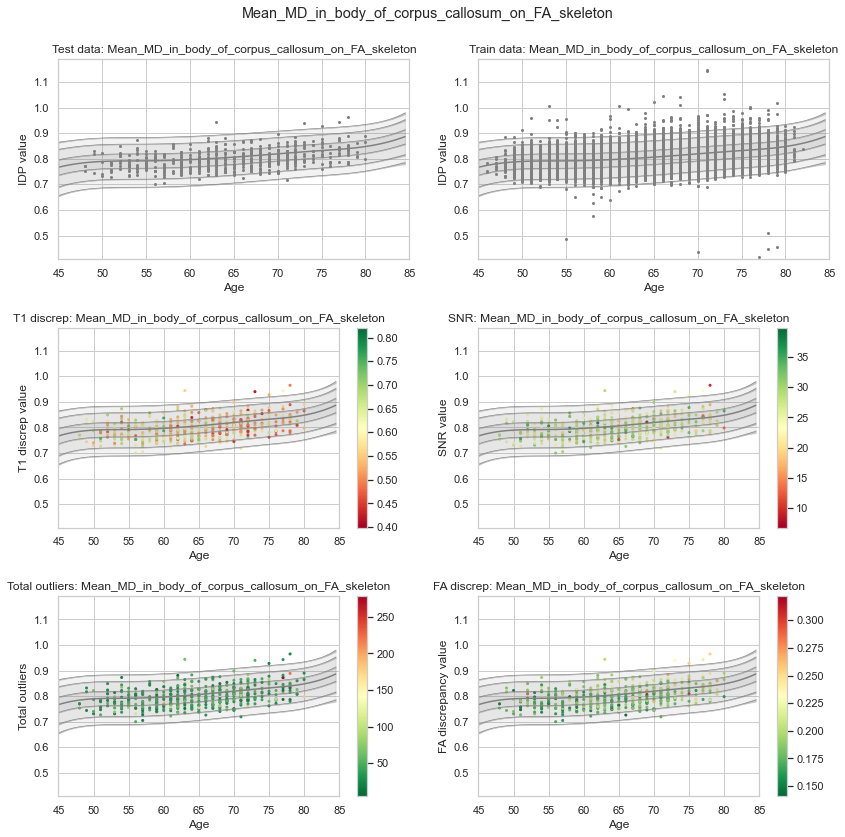

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03591932]), 'Rho': array([0.30661639]), 'pRho': array([1.63271918e-12]), 'SMSE': array([0.913046]), 'EXPV': array([0.09220714])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03591932]), 'Rho': array([0.30661639]), 'pRho': array([1.63271918e-12]), 'SMSE': array([0.913046]), 'EXPV': array([0.09220714])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03591932]), 'Rho': array([0.30661639]), 'pRho': array([1.63271918e-12]), 'SMSE': array([0.913046]), 'EXPV': array([0.09220714])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0

/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03591932]), 'Rho': array([0.30661639]), 'pRho': array([1.63271918e-12]), 'SMSE': array([0.913046]), 'EXPV': array([0.09220714])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


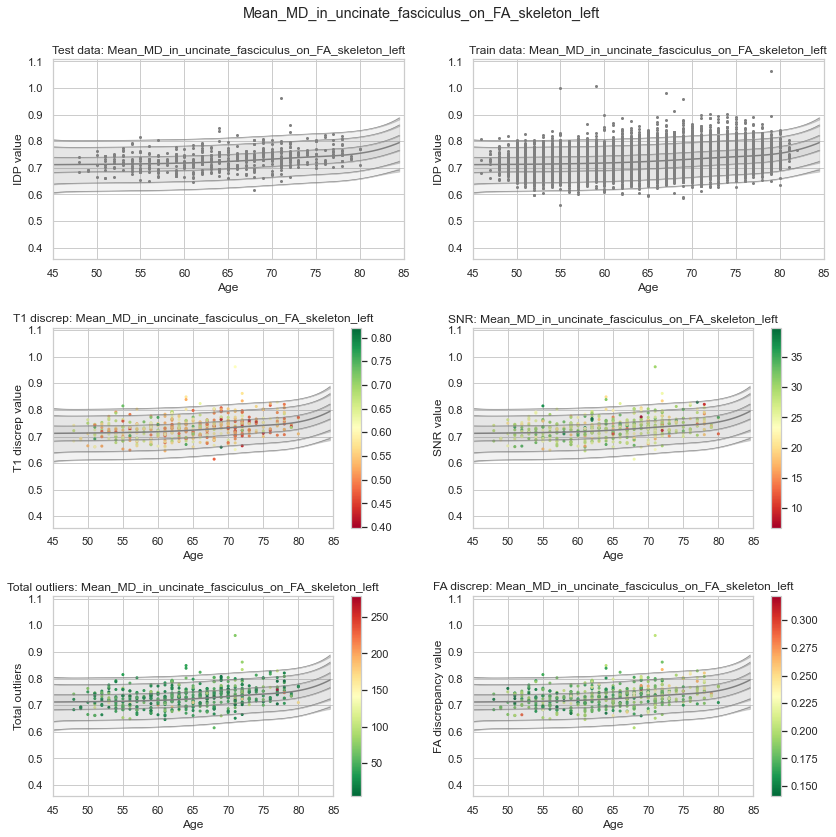

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03072455]), 'Rho': array([0.32231915]), 'pRho': array([9.24797135e-14]), 'SMSE': array([0.89698535]), 'EXPV': array([0.1030203])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03072455]), 'Rho': array([0.32231915]), 'pRho': array([9.24797135e-14]), 'SMSE': array([0.89698535]), 'EXPV': array([0.1030203])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03072455]), 'Rho': array([0.32231915]), 'pRho': array([9.24797135e-14]), 'SMSE': array([0.89698535]), 'EXPV': array([0.1030203])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03072455]), 'Rho': array([0.32231915]), 'pRho': array([9.24797135e-14]), 'SMSE': array([0.89698535]), 'EXPV': array([0.1030203])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03072455]), 'Rho': array([0.32231915]), 'pRho': array([9.24797135e-14]), 'SMSE': array([0.89698535]), 'EXPV': array([0.1030203])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03072455]), 'Rho': array([0.32231915]), 'pRho': array([9.24797135e-14]), 'SMSE': array([0.89698535]), 'EXPV': array([0.1030203])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


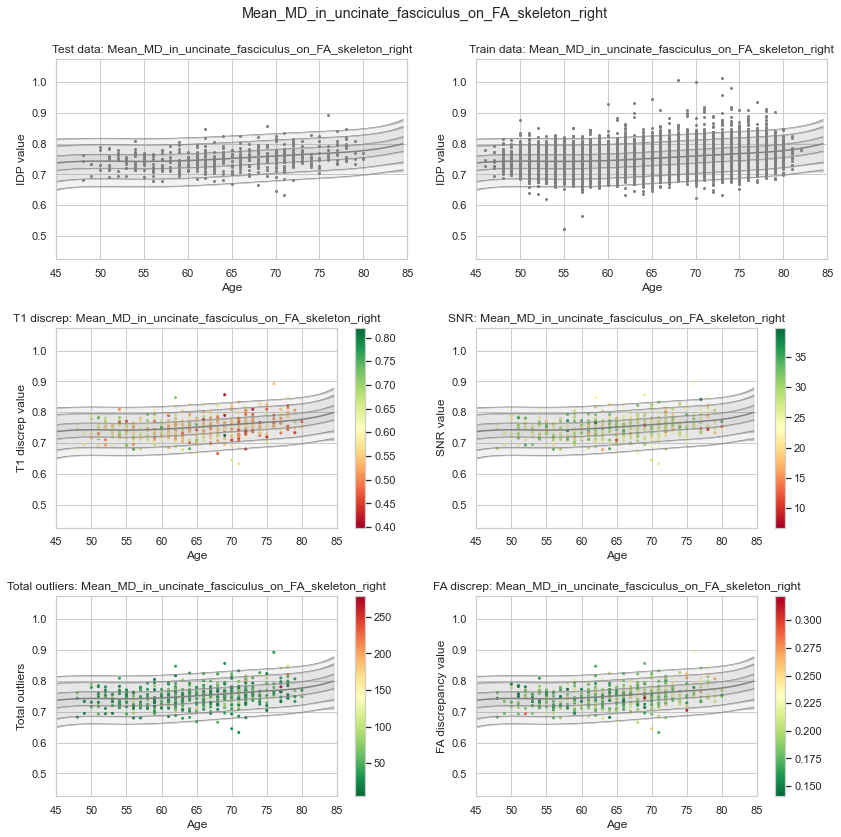

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.28225453]), 'Rho': array([0.49524261]), 'pRho': array([9.93837089e-34]), 'SMSE': array([0.75593304]), 'EXPV': array([0.24442328])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.28225453]), 'Rho': array([0.49524261]), 'pRho': array([9.93837089e-34]), 'SMSE': array([0.75593304]), 'EXPV': array([0.24442328])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.28225453]), 'Rho': array([0.49524261]), 'pRho': array([9.93837089e-34]), 'SMSE': array([0.75593304]), 'EXPV': array([0.24442328])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.28225453]), 'Rho': array([0.49524261]), 'pRho': array([9.93837089e-34]), 'SMSE': array([0.75593304]), 'EXPV': array([0.24442328])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.28225453]), 'Rho': array([0.49524261]), 'pRho': array([9.93837089e-34]), 'SMSE': array([0.75593304]), 'EXPV': array([0.24442328])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.28225453]), 'Rho': array([0.49524261]), 'pRho': array([9.93837089e-34]), 'SMSE': array([0.75593304]), 'EXPV': array([0.24442328])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


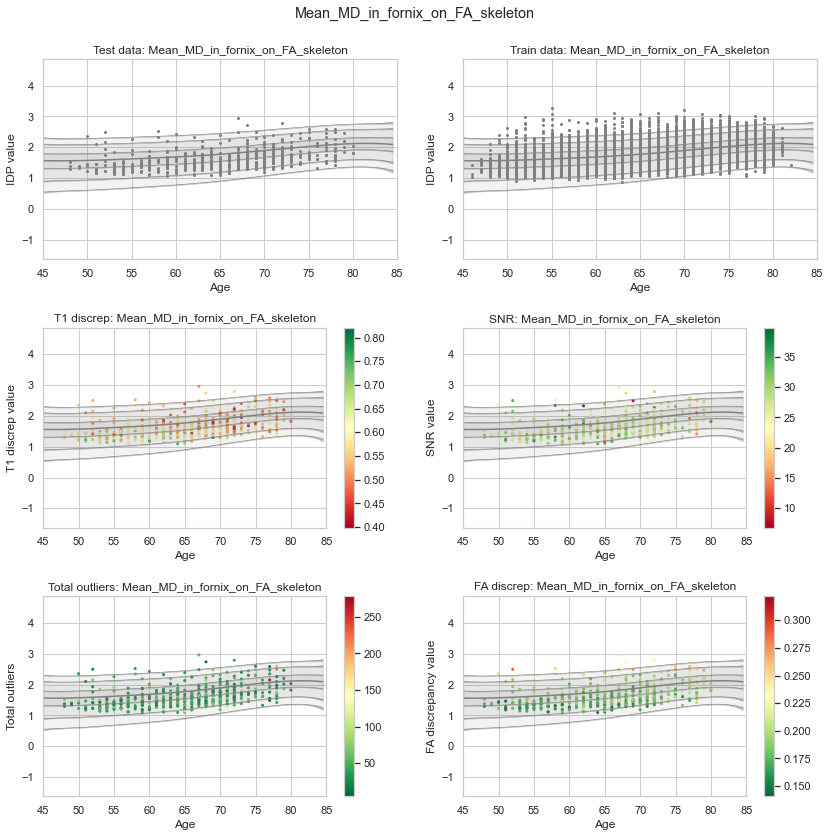

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06950976]), 'Rho': array([0.08953648]), 'pRho': array([0.04534487]), 'SMSE': array([1.00458896]), 'EXPV': array([0.00767647])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06950976]), 'Rho': array([0.08953648]), 'pRho': array([0.04534487]), 'SMSE': array([1.00458896]), 'EXPV': array([0.00767647])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06950976]), 'Rho': array([0.08953648]), 'pRho': array([0.04534487]), 'SMSE': array([1.00458896]), 'EXPV': array([0.00767647])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06950976]), 'Rho': array([0.08953648]), 'pRho': array([0.04534487]), 'SMSE': array([1.00458896]), 'EXPV': array([0.00767647])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06950976]), 'Rho': array([0.08953648]), 'pRho': array([0.04534487]), 'SMSE': array([1.00458896]), 'EXPV': array([0.00767647])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06950976]), 'Rho': array([0.08953648]), 'pRho': array([0.04534487]), 'SMSE': array([1.00458896]), 'EXPV': array([0.00767647])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


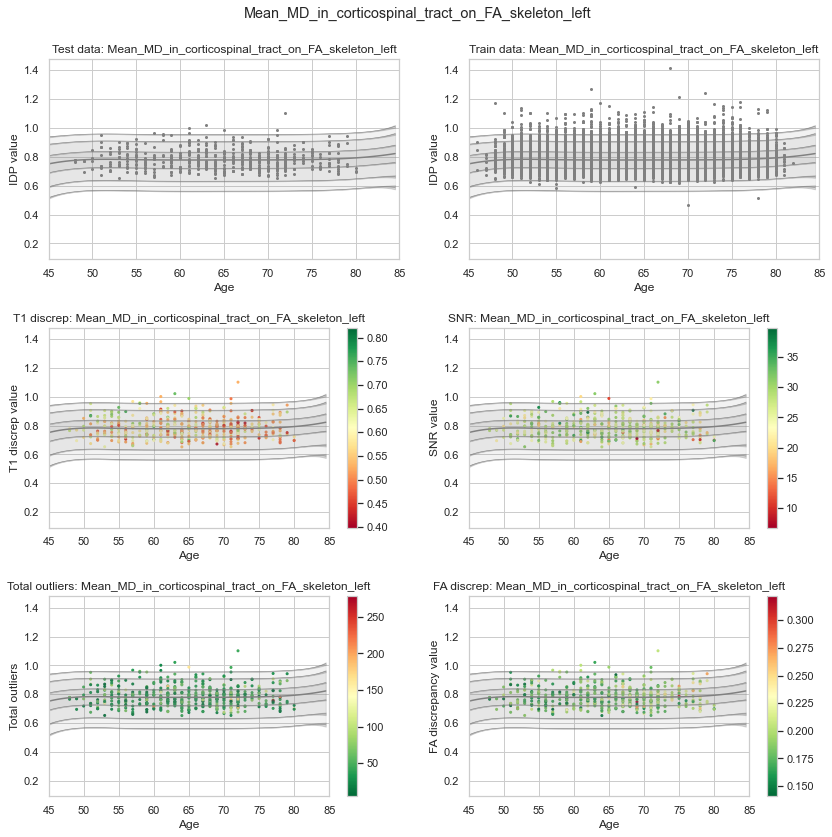

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03282261]), 'Rho': array([0.15854729]), 'pRho': array([0.00036435]), 'SMSE': array([0.98132927]), 'EXPV': array([0.02011991])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03282261]), 'Rho': array([0.15854729]), 'pRho': array([0.00036435]), 'SMSE': array([0.98132927]), 'EXPV': array([0.02011991])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03282261]), 'Rho': array([0.15854729]), 'pRho': array([0.00036435]), 'SMSE': array([0.98132927]), 'EXPV': array([0.02011991])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03282261]), 'Rho': array([0.15854729]), 'pRho': array([0.00036435]), 'SMSE': array([0.98132927]), 'EXPV': array([0.02011991])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03282261]), 'Rho': array([0.15854729]), 'pRho': array([0.00036435]), 'SMSE': array([0.98132927]), 'EXPV': array([0.02011991])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.03282261]), 'Rho': array([0.15854729]), 'pRho': array([0.00036435]), 'SMSE': array([0.98132927]), 'EXPV': array([0.02011991])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


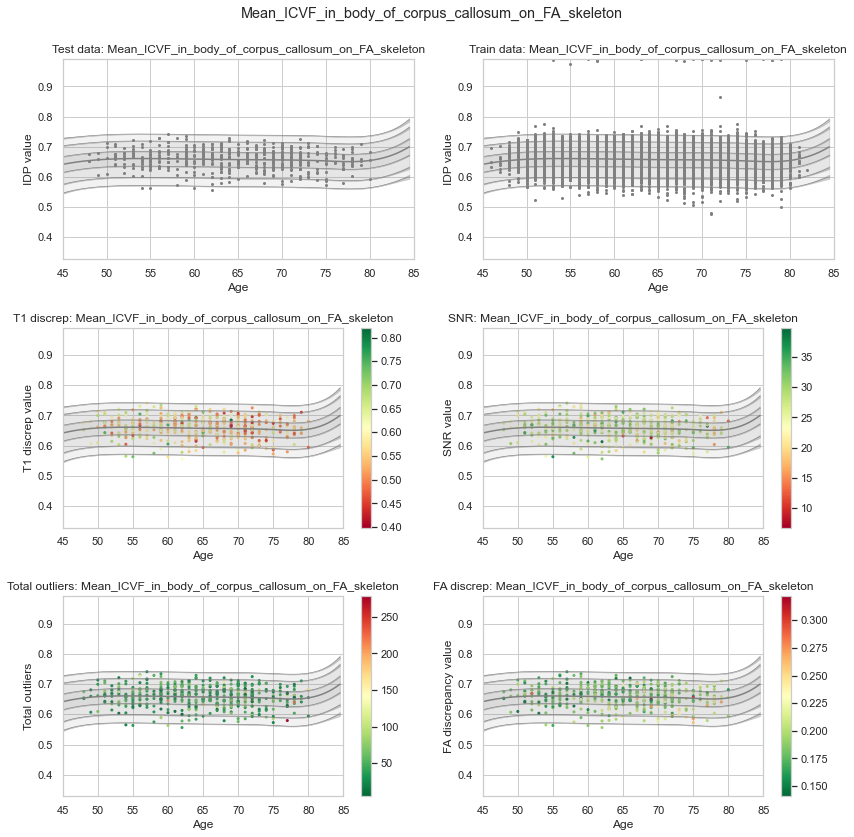

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0284036]), 'Rho': array([0.32788104]), 'pRho': array([3.20226695e-14]), 'SMSE': array([0.89608563]), 'EXPV': array([0.10616129])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0284036]), 'Rho': array([0.32788104]), 'pRho': array([3.20226695e-14]), 'SMSE': array([0.89608563]), 'EXPV': array([0.10616129])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0284036]), 'Rho': array([0.32788104]), 'pRho': array([3.20226695e-14]), 'SMSE': array([0.89608563]), 'EXPV': array([0.10616129])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0284036]), 'Rho': array([0.32788104]), 'pRho': array([3.20226695e-14]), 'SMSE': array([0.89608563]), 'EXPV': array([0.10616129])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0284036]), 'Rho': array([0.32788104]), 'pRho': array([3.20226695e-14]), 'SMSE': array([0.89608563]), 'EXPV': array([0.10616129])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0284036]), 'Rho': array([0.32788104]), 'pRho': array([3.20226695e-14]), 'SMSE': array([0.89608563]), 'EXPV': array([0.10616129])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


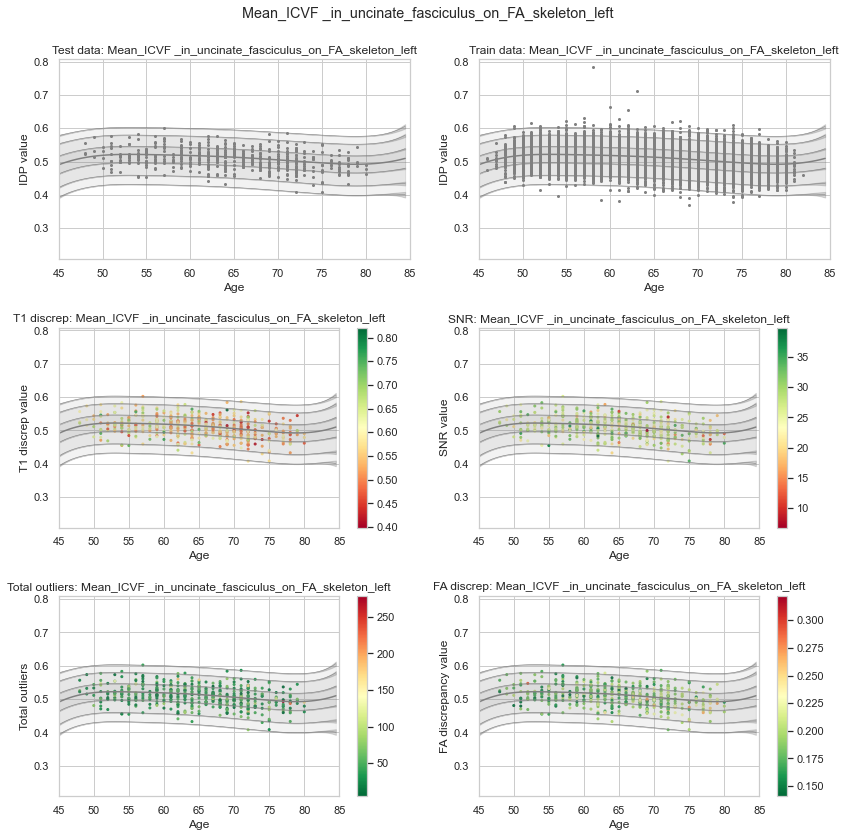

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02826456]), 'Rho': array([0.31697341]), 'pRho': array([2.50788283e-13]), 'SMSE': array([0.90272443]), 'EXPV': array([0.09974286])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02826456]), 'Rho': array([0.31697341]), 'pRho': array([2.50788283e-13]), 'SMSE': array([0.90272443]), 'EXPV': array([0.09974286])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02826456]), 'Rho': array([0.31697341]), 'pRho': array([2.50788283e-13]), 'SMSE': array([0.90272443]), 'EXPV': array([0.09974286])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02826456]), 'Rho': array([0.31697341]), 'pRho': array([2.50788283e-13]), 'SMSE': array([0.90272443]), 'EXPV': array([0.09974286])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02826456]), 'Rho': array([0.31697341]), 'pRho': array([2.50788283e-13]), 'SMSE': array([0.90272443]), 'EXPV': array([0.09974286])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.02826456]), 'Rho': array([0.31697341]), 'pRho': array([2.50788283e-13]), 'SMSE': array([0.90272443]), 'EXPV': array([0.09974286])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


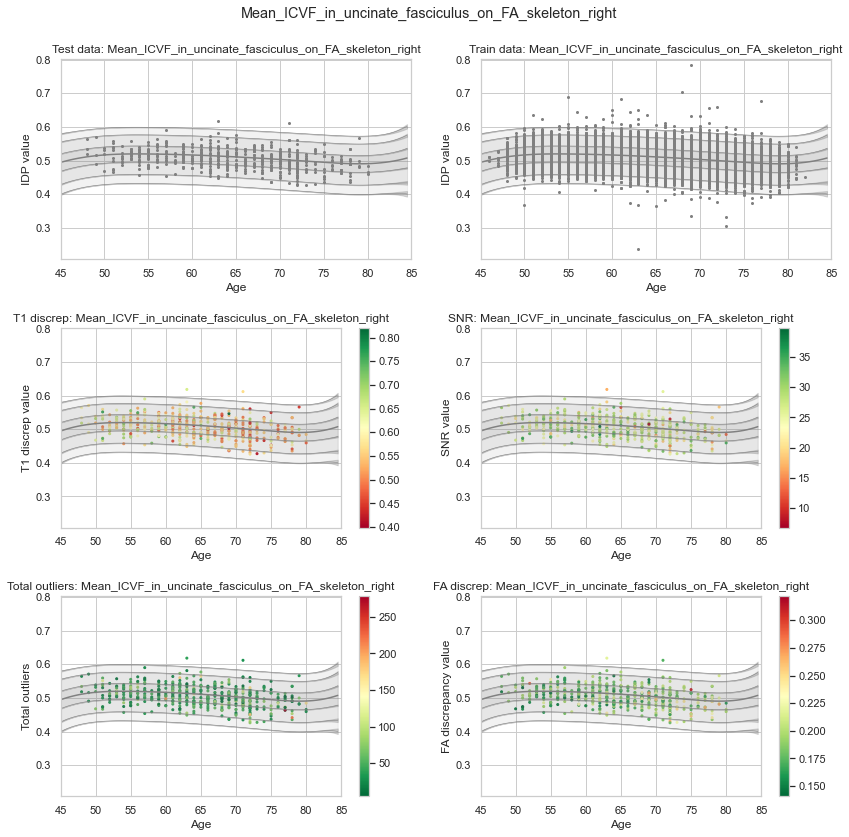

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06665886]), 'Rho': array([0.2250944]), 'pRho': array([3.29803951e-07]), 'SMSE': array([0.95062275]), 'EXPV': array([0.04945492])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06665886]), 'Rho': array([0.2250944]), 'pRho': array([3.29803951e-07]), 'SMSE': array([0.95062275]), 'EXPV': array([0.04945492])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06665886]), 'Rho': array([0.2250944]), 'pRho': array([3.29803951e-07]), 'SMSE': array([0.95062275]), 'EXPV': array([0.04945492])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06665886]), 'Rho': array([0.2250944]), 'pRho': array([3.29803951e-07]), 'SMSE': array([0.95062275]), 'EXPV': array([0.04945492])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06665886]), 'Rho': array([0.2250944]), 'pRho': array([3.29803951e-07]), 'SMSE': array([0.95062275]), 'EXPV': array([0.04945492])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.06665886]), 'Rho': array([0.2250944]), 'pRho': array([3.29803951e-07]), 'SMSE': array([0.95062275]), 'EXPV': array([0.04945492])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


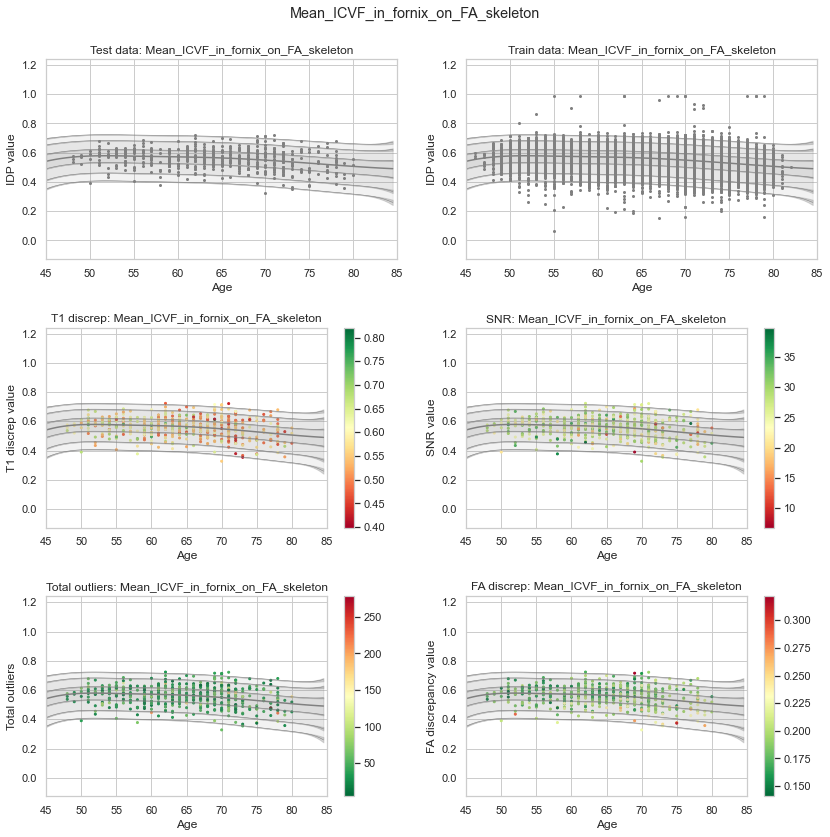

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04336997]), 'Rho': array([0.17277269]), 'pRho': array([9.99415581e-05]), 'SMSE': array([0.97121457]), 'EXPV': array([0.02933893])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04336997]), 'Rho': array([0.17277269]), 'pRho': array([9.99415581e-05]), 'SMSE': array([0.97121457]), 'EXPV': array([0.02933893])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04336997]), 'Rho': array([0.17277269]), 'pRho': array([9.99415581e-05]), 'SMSE': array([0.97121457]), 'EXPV': array([0.02933893])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04336997]), 'Rho': array([0.17277269]), 'pRho': array([9.99415581e-05]), 'SMSE': array([0.97121457]), 'EXPV': array([0.02933893])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04336997]), 'Rho': array([0.17277269]), 'pRho': array([9.99415581e-05]), 'SMSE': array([0.97121457]), 'EXPV': array([0.02933893])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04336997]), 'Rho': array([0.17277269]), 'pRho': array([9.99415581e-05]), 'SMSE': array([0.97121457]), 'EXPV': array([0.02933893])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


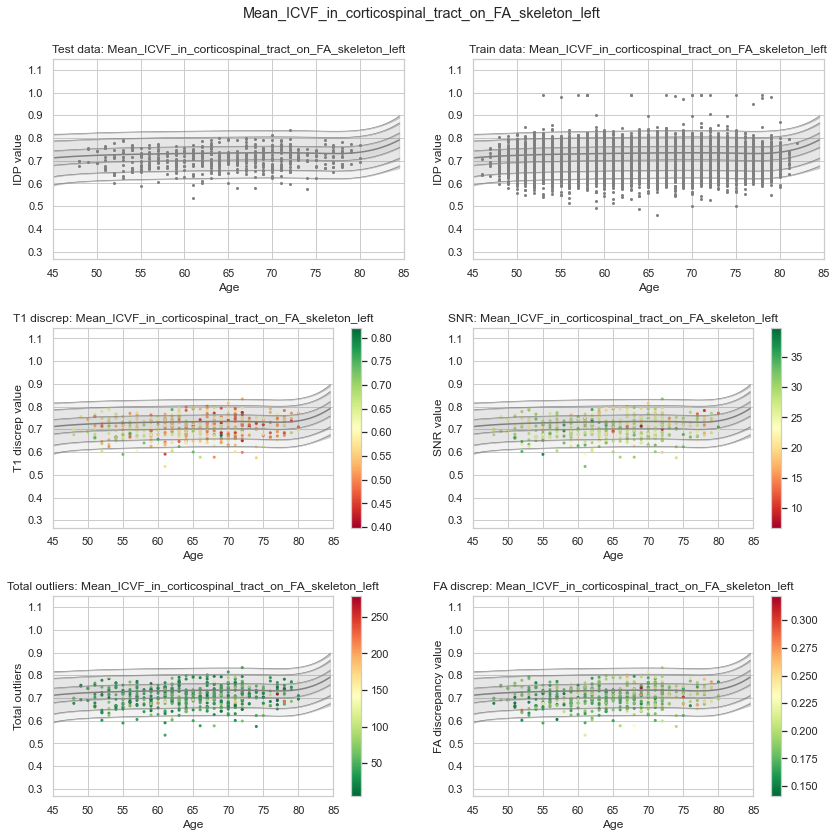

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0441188]), 'Rho': array([0.2030145]), 'pRho': array([4.43956738e-06]), 'SMSE': array([0.96073253]), 'EXPV': array([0.04085767])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0441188]), 'Rho': array([0.2030145]), 'pRho': array([4.43956738e-06]), 'SMSE': array([0.96073253]), 'EXPV': array([0.04085767])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0441188]), 'Rho': array([0.2030145]), 'pRho': array([4.43956738e-06]), 'SMSE': array([0.96073253]), 'EXPV': array([0.04085767])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0441188]), 'Rho': array([0.2030145]), 'pRho': array([4.43956738e-06]), 'SMSE': array([0.96073253]), 'EXPV': array([0.04085767])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0441188]), 'Rho': array([0.2030145]), 'pRho': array([4.43956738e-06]), 'SMSE': array([0.96073253]), 'EXPV': array([0.04085767])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.0441188]), 'Rho': array([0.2030145]), 'pRho': array([4.43956738e-06]), 'SMSE': array([0.96073253]), 'EXPV': array([0.04085767])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


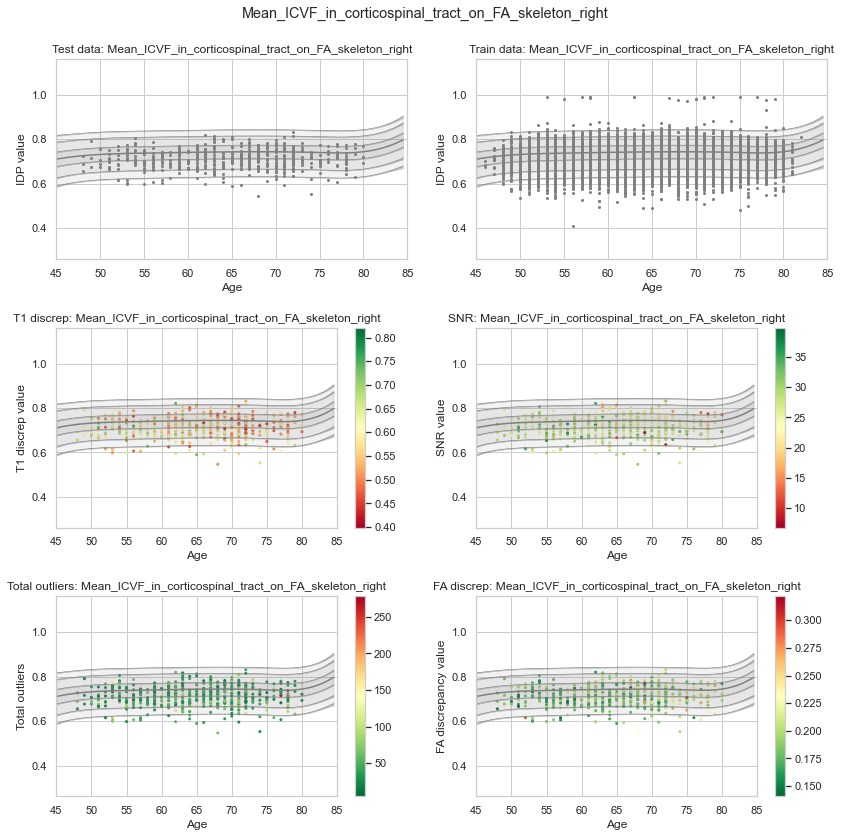

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01735565]), 'Rho': array([0.4811337]), 'pRho': array([1.40029263e-31]), 'SMSE': array([0.76974681]), 'EXPV': array([0.23052343])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01735565]), 'Rho': array([0.4811337]), 'pRho': array([1.40029263e-31]), 'SMSE': array([0.76974681]), 'EXPV': array([0.23052343])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01735565]), 'Rho': array([0.4811337]), 'pRho': array([1.40029263e-31]), 'SMSE': array([0.76974681]), 'EXPV': array([0.23052343])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01735565]), 'Rho': array([0.4811337]), 'pRho': array([1.40029263e-31]), 'SMSE': array([0.76974681]), 'EXPV': array([0.23052343])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01735565]), 'Rho': array([0.4811337]), 'pRho': array([1.40029263e-31]), 'SMSE': array([0.76974681]), 'EXPV': array([0.23052343])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01735565]), 'Rho': array([0.4811337]), 'pRho': array([1.40029263e-31]), 'SMSE': array([0.76974681]), 'EXPV': array([0.23052343])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


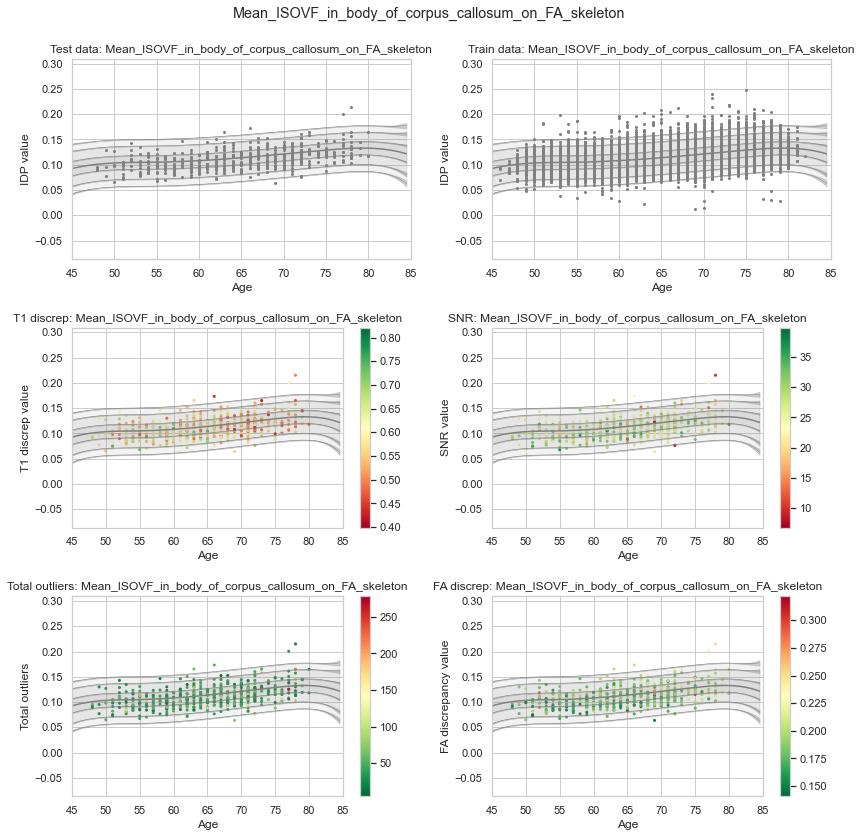

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01364692]), 'Rho': array([0.16148432]), 'pRho': array([0.00028141]), 'SMSE': array([0.98162856]), 'EXPV': array([0.02463765])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01364692]), 'Rho': array([0.16148432]), 'pRho': array([0.00028141]), 'SMSE': array([0.98162856]), 'EXPV': array([0.02463765])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01364692]), 'Rho': array([0.16148432]), 'pRho': array([0.00028141]), 'SMSE': array([0.98162856]), 'EXPV': array([0.02463765])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01364692]), 'Rho': array([0.16148432]), 'pRho': array([0.00028141]), 'SMSE': array([0.98162856]), 'EXPV': array([0.02463765])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01364692]), 'Rho': array([0.16148432]), 'pRho': array([0.00028141]), 'SMSE': array([0.98162856]), 'EXPV': array([0.02463765])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01364692]), 'Rho': array([0.16148432]), 'pRho': array([0.00028141]), 'SMSE': array([0.98162856]), 'EXPV': array([0.02463765])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


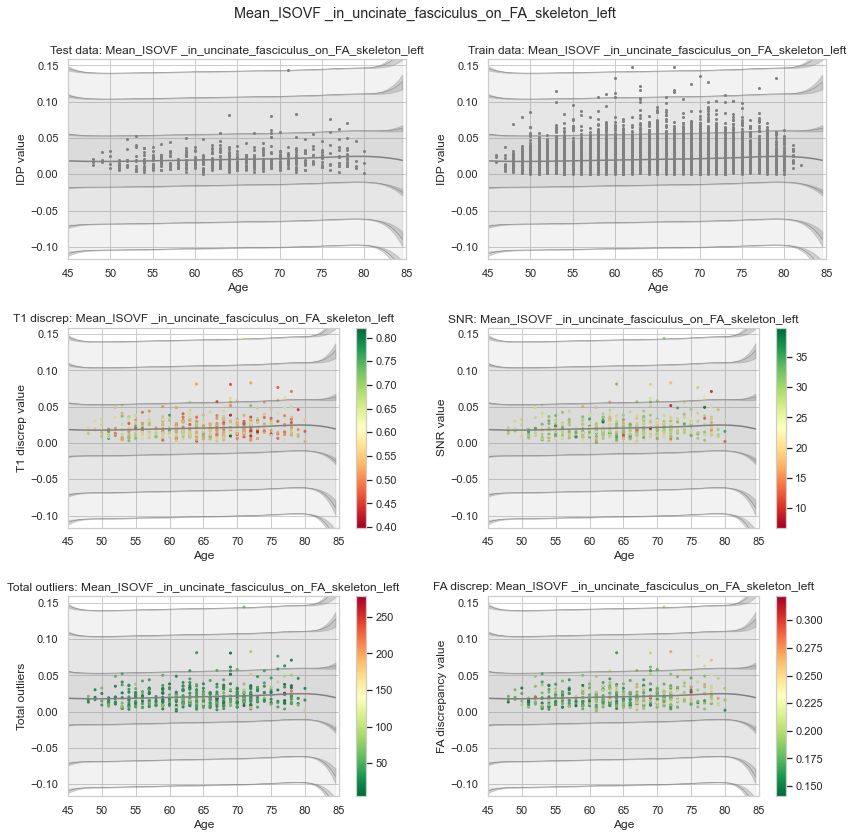

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01188308]), 'Rho': array([0.20595452]), 'pRho': array([3.19188925e-06]), 'SMSE': array([0.95917302]), 'EXPV': array([0.04085387])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01188308]), 'Rho': array([0.20595452]), 'pRho': array([3.19188925e-06]), 'SMSE': array([0.95917302]), 'EXPV': array([0.04085387])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01188308]), 'Rho': array([0.20595452]), 'pRho': array([3.19188925e-06]), 'SMSE': array([0.95917302]), 'EXPV': array([0.04085387])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01188308]), 'Rho': array([0.20595452]), 'pRho': array([3.19188925e-06]), 'SMSE': array([0.95917302]), 'EXPV': array([0.04085387])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01188308]), 'Rho': array([0.20595452]), 'pRho': array([3.19188925e-06]), 'SMSE': array([0.95917302]), 'EXPV': array([0.04085387])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.01188308]), 'Rho': array([0.20595452]), 'pRho': array([3.19188925e-06]), 'SMSE': array([0.95917302]), 'EXPV': array([0.04085387])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


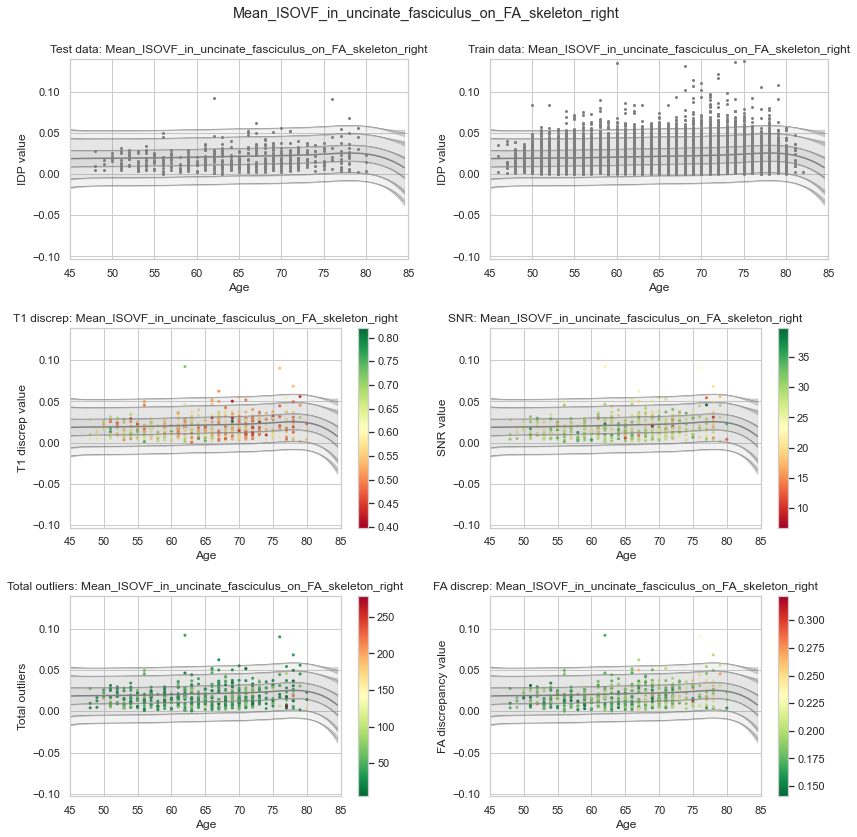

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11891982]), 'Rho': array([0.54529414]), 'pRho': array([2.44524208e-42]), 'SMSE': array([0.70364477]), 'EXPV': array([0.29694068])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11891982]), 'Rho': array([0.54529414]), 'pRho': array([2.44524208e-42]), 'SMSE': array([0.70364477]), 'EXPV': array([0.29694068])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11891982]), 'Rho': array([0.54529414]), 'pRho': array([2.44524208e-42]), 'SMSE': array([0.70364477]), 'EXPV': array([0.29694068])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11891982]), 'Rho': array([0.54529414]), 'pRho': array([2.44524208e-42]), 'SMSE': array([0.70364477]), 'EXPV': array([0.29694068])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11891982]), 'Rho': array([0.54529414]), 'pRho': array([2.44524208e-42]), 'SMSE': array([0.70364477]), 'EXPV': array([0.29694068])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.11891982]), 'Rho': array([0.54529414]), 'pRho': array([2.44524208e-42]), 'SMSE': array([0.70364477]), 'EXPV': array([0.29694068])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


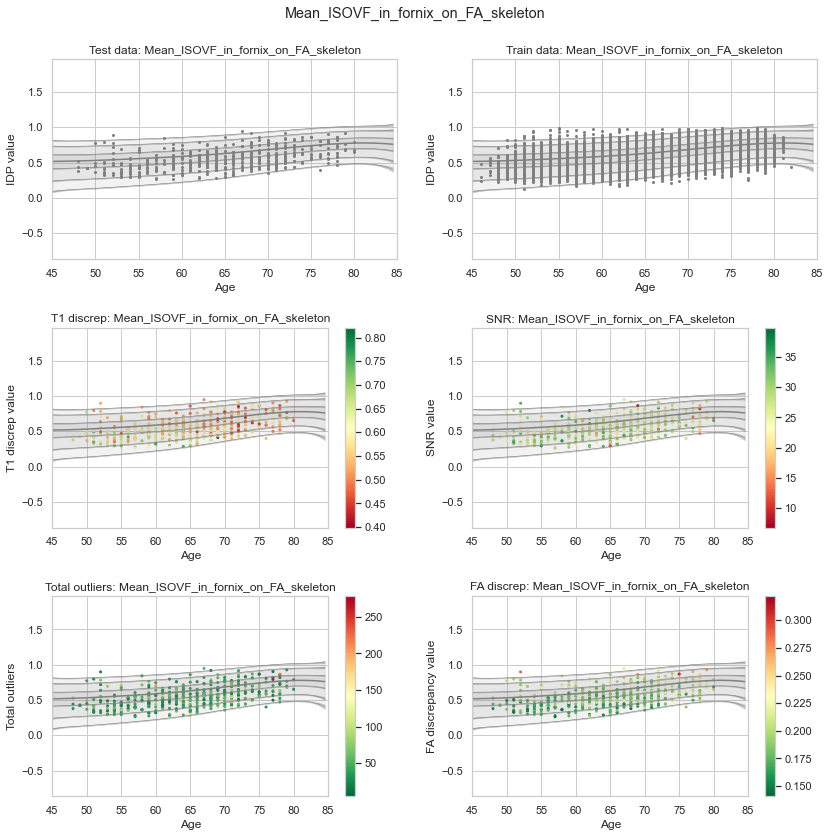

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04591738]), 'Rho': array([0.06866227]), 'pRho': array([0.12524272]), 'SMSE': array([1.00767551]), 'EXPV': array([0.00437952])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04591738]), 'Rho': array([0.06866227]), 'pRho': array([0.12524272]), 'SMSE': array([1.00767551]), 'EXPV': array([0.00437952])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04591738]), 'Rho': array([0.06866227]), 'pRho': array([0.12524272]), 'SMSE': array([1.00767551]), 'EXPV': array([0.00437952])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04591738]), 'Rho': array([0.06866227]), 'pRho': array([0.12524272]), 'SMSE': array([1.00767551]), 'EXPV': array([0.00437952])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04591738]), 'Rho': array([0.06866227]), 'pRho': array([0.12524272]), 'SMSE': array([1.00767551]), 'EXPV': array([0.00437952])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.04591738]), 'Rho': array([0.06866227]), 'pRho': array([0.12524272]), 'SMSE': array([1.00767551]), 'EXPV': array([0.00437952])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


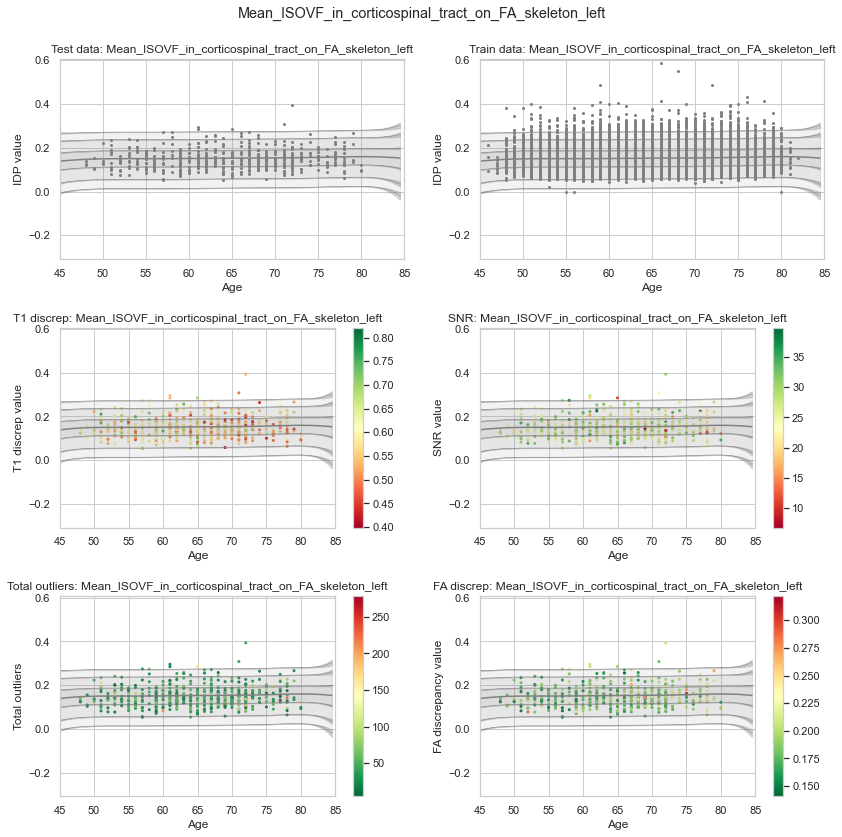

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.05486324]), 'Rho': array([0.11358418]), 'pRho': array([0.01098539]), 'SMSE': array([0.99337421]), 'EXPV': array([0.01012551])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.05486324]), 'Rho': array([0.11358418]), 'pRho': array([0.01098539]), 'SMSE': array([0.99337421]), 'EXPV': array([0.01012551])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.05486324]), 'Rho': array([0.11358418]), 'pRho': array([0.01098539]), 'SMSE': array([0.99337421]), 'EXPV': array([0.01012551])}


/tmp/ipykernel_27712/5736934.py:216: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:300: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()
/tmp/ipykernel_27712/5736934.py:384: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.05486324]), 'Rho': array([0.11358418]), 'pRho': array([0.01098539]), 'SMSE': array([0.99337421]), 'EXPV': array([0.01012551])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.05486324]), 'Rho': array([0.11358418]), 'pRho': array([0.01098539]), 'SMSE': array([0.99337421]), 'EXPV': array([0.01012551])}
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
metrics: {'RMSE': array([0.05486324]), 'Rho': array([0.11358418]), 'pRho': array([0.01098539]), 'SMSE': array([0.99337421]), 'EXPV': array([0.01012551])}


/tmp/ipykernel_27712/5736934.py:468: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


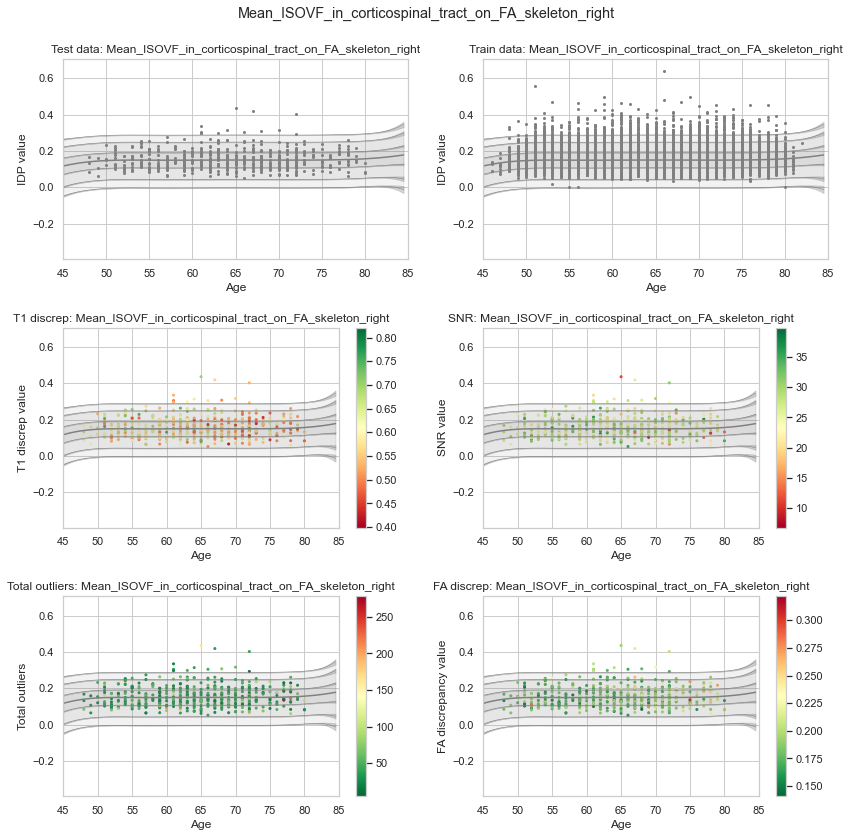

In [70]:
for idp_num, idp in enumerate(idp_ids):
#     if idp_num == 7:
        # TEST DATA #####################################################################################################
        fig1 = plt.figure(figsize=(12, 12))

        plt.subplot(3,2,1)
        sns.set(style='whitegrid')
        idp_dir = os.path.join(out_dir, idp)
        os.chdir(idp_dir)

        # load the true data points
        yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
        s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
        y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))
        idx = range(0, len(X_te))
        
        # set up the covariates for the dummy data
        print('Making predictions with dummy covariates (for visualisation)')
        yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')

        # load the normative model
        with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 

        # get the warp and warp parameters
        W = nm.blr.warp
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

        # first, we warp predictions for the true data and compute evaluation metrics
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
        print('metrics:', evaluate(y_te, med_te))

        # then, we warp dummy predictions to create the plots
        med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

        # extract the different variance components to visualise
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
        s2n = 1/beta # variation (aleatoric uncertainty)
        s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

        # plot the data points
        plt.scatter(X_te[idx,1], y_te, s=4, color=clr, alpha = 1)

        # plot the median of the dummy data
        plt.plot(xx, med, clr)

        # fill the gaps in between the centiles
        junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
        plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

        # make the width of each centile proportional to the epistemic uncertainty
        junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
        junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
        plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

        # plot actual centile lines
        plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

        plt.xlabel('Age')
        plt.ylabel('IDP value') 
        plt.title('Test data: ' + idp)
        plt.xlim((45,85))
        plt.ylim((np.mean(y_te)-10*np.std(y_te)), (np.mean(y_te)+10*np.std(y_te)))

        # TRAIN DATA #####################################################################################################
        plt.subplot(3,2,2)
        sns.set(style='whitegrid')
        idp_dir = os.path.join(out_dir, idp)
        os.chdir(idp_dir)

        # load the true data points
        yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
        s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
        y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))
        y_tr = load_2d(os.path.join(idp_dir, 'resp_tr.txt'))

        # set up the covariates for the dummy data
        print('Making predictions with dummy covariates (for visualisation)')
        yhat, s2 = predict(cov_file_dummy, 
                           alg = 'blr', 
                           respfile = None, 
                           model_path = os.path.join(idp_dir,'Models'), 
                           outputsuffix = '_dummy')

        # load the normative model
        with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 

        # get the warp and warp parameters
        W = nm.blr.warp
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

        # first, we warp predictions for the true data and compute evaluation metrics
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
        print('metrics:', evaluate(y_te, med_te))

        # then, we warp dummy predictions to create the plots
        med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

        # extract the different variance components to visualise
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
        s2n = 1/beta # variation (aleatoric uncertainty)
        s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

        # plot the (adjusted) data points
        plt.scatter(df_tr['age'], y_tr, s=4, color=clr, alpha = 1)

        # plot the median of the dummy data
        plt.plot(xx, med, clr)

        # fill the gaps in between the centiles
        junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
        plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

        # make the width of each centile proportional to the epistemic uncertainty
        junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
        junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
        plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

        # plot actual centile lines
        plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

        plt.xlabel('Age')
        plt.ylabel('IDP value') 
        plt.title('Train data: ' + idp)

        plt.xlim((45,85))
        plt.ylim((np.mean(y_te)-10*np.std(y_te)), (np.mean(y_te)+10*np.std(y_te)))

        # T1 vs DWI discrepancy #####################################################################################################
        plt.subplot(3,2,3)
        sns.set(style='whitegrid')
        clr = 'gray'
        idp_dir = os.path.join(out_dir, idp)
        os.chdir(idp_dir)

        # load the true data points
        yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
        s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
        y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

        # set up the covariates for the dummy data
        print('Making predictions with dummy covariates (for visualisation)')
        yhat, s2 = predict(cov_file_dummy, 
                           alg = 'blr', 
                           respfile = None, 
                           model_path = os.path.join(idp_dir,'Models'), 
                           outputsuffix = '_dummy')

        # load the normative model
        with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 

        # get the warp and warp parameters
        W = nm.blr.warp
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

        # first, we warp predictions for the true data and compute evaluation metrics
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
        print('metrics:', evaluate(y_te, med_te))

        # then, we warp dummy predictions to create the plots
        med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

        # extract the different variance components to visualise
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
        s2n = 1/beta # variation (aleatoric uncertainty)
        s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

        # plot the data points
        labels = np.array(qc500_features["T1_discrep"])
        plt.scatter(X_te[:,1], y_te, s=4, c=labels, cmap = 'RdYlGn', alpha = 1)
        plt.colorbar()    
        # plot the median of the dummy data
        plt.plot(xx, med, clr)

        # fill the gaps in between the centiles
        junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
        plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

        # make the width of each centile proportional to the epistemic uncertainty
        junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
        junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
        plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

        # plot actual centile lines
        plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

        plt.xlabel('Age')
        plt.ylabel('T1 discrep value') 
        plt.title('T1 discrep: ' +idp)
        plt.xlim((45,85))
        plt.ylim((np.mean(y_te)-10*np.std(y_te)), (np.mean(y_te)+10*np.std(y_te)))

        # SNR #####################################################################################################
        plt.subplot(3,2,4)
        sns.set(style='whitegrid')
        clr = 'gray'
        idp_dir = os.path.join(out_dir, idp)
        os.chdir(idp_dir)

        # load the true data points
        yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
        s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
        y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

        # set up the covariates for the dummy data
        print('Making predictions with dummy covariates (for visualisation)')
        yhat, s2 = predict(cov_file_dummy, 
                           alg = 'blr', 
                           respfile = None, 
                           model_path = os.path.join(idp_dir,'Models'), 
                           outputsuffix = '_dummy')

        # load the normative model
        with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 

        # get the warp and warp parameters
        W = nm.blr.warp
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

        # first, we warp predictions for the true data and compute evaluation metrics
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
        print('metrics:', evaluate(y_te, med_te))

        # then, we warp dummy predictions to create the plots
        med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

        # extract the different variance components to visualise
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
        s2n = 1/beta # variation (aleatoric uncertainty)
        s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

        # plot the (adjusted) data points
        labels = np.array(qc500_features["SNR"])
        plt.scatter(X_te[:,1], y_te, s=4, c=labels, cmap = 'RdYlGn', alpha = 1)
        plt.colorbar()    
        # plot the median of the dummy data
        plt.plot(xx, med, clr)

        # fill the gaps in between the centiles
        junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
        plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

        # make the width of each centile proportional to the epistemic uncertainty
        junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
        junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
        plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

        # plot actual centile lines
        plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

        plt.xlabel('Age')
        plt.ylabel('SNR value') 
        plt.title('SNR: ' + idp)
        plt.xlim((45,85))
        plt.ylim((np.mean(y_te)-10*np.std(y_te)), (np.mean(y_te)+10*np.std(y_te)))
        
        # Total Outliers #####################################################################################################
        plt.subplot(3,2,5)
        sns.set(style='whitegrid')
        clr = 'gray'
        idp_dir = os.path.join(out_dir, idp)
        os.chdir(idp_dir)

        # load the true data points
        yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
        s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
        y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

        # set up the covariates for the dummy data
        print('Making predictions with dummy covariates (for visualisation)')
        yhat, s2 = predict(cov_file_dummy, 
                           alg = 'blr', 
                           respfile = None, 
                           model_path = os.path.join(idp_dir,'Models'), 
                           outputsuffix = '_dummy')

        # load the normative model
        with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 

        # get the warp and warp parameters
        W = nm.blr.warp
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

        # first, we warp predictions for the true data and compute evaluation metrics
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
        print('metrics:', evaluate(y_te, med_te))

        # then, we warp dummy predictions to create the plots
        med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

        # extract the different variance components to visualise
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
        s2n = 1/beta # variation (aleatoric uncertainty)
        s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

        # plot the data points
        labels = np.array(qc500_features["No_outliers_corrected"])
        plt.scatter(X_te[:,1], y_te, s=4, c=labels, cmap = 'RdYlGn_r', alpha = 1)
        plt.colorbar()    
        # plot the median of the dummy data
        plt.plot(xx, med, clr)

        # fill the gaps in between the centiles
        junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
        plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

        # make the width of each centile proportional to the epistemic uncertainty
        junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
        junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
        plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

        # plot actual centile lines
        plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

        plt.xlabel('Age')
        plt.ylabel('Total outliers') 
        plt.title('Total outliers: ' + idp)
        plt.xlim((45,85))
        plt.ylim((np.mean(y_te)-10*np.std(y_te)), (np.mean(y_te)+10*np.std(y_te)))

        # FA vs T1 discrepancy #####################################################################################################
        plt.subplot(3,2,6)
        sns.set(style='whitegrid')
        clr = 'gray'
        idp_dir = os.path.join(out_dir, idp)
        os.chdir(idp_dir)

        # load the true data points
        yhat_te = load_2d(os.path.join(idp_dir, 'yhat_predict.txt'))
        s2_te = load_2d(os.path.join(idp_dir, 'ys2_predict.txt'))
        y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))

        # set up the covariates for the dummy data
        print('Making predictions with dummy covariates (for visualisation)')
        yhat, s2 = predict(cov_file_dummy, 
                           alg = 'blr', 
                           respfile = None, 
                           model_path = os.path.join(idp_dir,'Models'), 
                           outputsuffix = '_dummy')

        # load the normative model
        with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
            nm = pickle.load(handle) 

        # get the warp and warp parameters
        W = nm.blr.warp
        warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

        # first, we warp predictions for the true data and compute evaluation metrics
        med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
        med_te = med_te[:, np.newaxis]
        print('metrics:', evaluate(y_te, med_te))

        # then, we warp dummy predictions to create the plots
        med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

        # extract the different variance components to visualise
        beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
        s2n = 1/beta # variation (aleatoric uncertainty)
        s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

        # plot the data points
        labels = np.array(qc500_features["FA_qc"])
        plt.scatter(X_te[:,1], y_te, s=4, c=labels, cmap = 'RdYlGn_r', alpha = 1)
        plt.colorbar()    
        # plot the median of the dummy data
        plt.plot(xx, med, clr)

        # fill the gaps in between the centiles
        junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
        plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
        plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

        # make the width of each centile proportional to the epistemic uncertainty
        junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
        junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
        junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
        junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
        plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
        plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

        # plot actual centile lines
        plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
        plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

        plt.xlabel('Age')
        plt.ylabel('FA discrepancy value') 
        plt.title('FA discrep: ' + idp)
        plt.xlim((45,85))
        plt.ylim((np.mean(y_te)-10*np.std(y_te)), (np.mean(y_te)+10*np.std(y_te)))

        fig1.tight_layout(pad = 2)
        plt.suptitle(idp)
        fig1.subplots_adjust(top=0.92)
        plt.savefig(os.path.join('/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/braincharts/Subplots/', idp))
        plt.show()
os.chdir(out_dir)

### Highlight outlier

In [26]:
homedir = '/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm'
save_path = os.path.join(homedir,'outliers_params.pkl')
outliers_params = pd.read_pickle(save_path)

In [63]:
len(idp_ids)

23

Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outputs ...
Making predictions with dummy covariates (for visualisation)
Loading data ...
Prediction by model  1 of 1
Writing outp

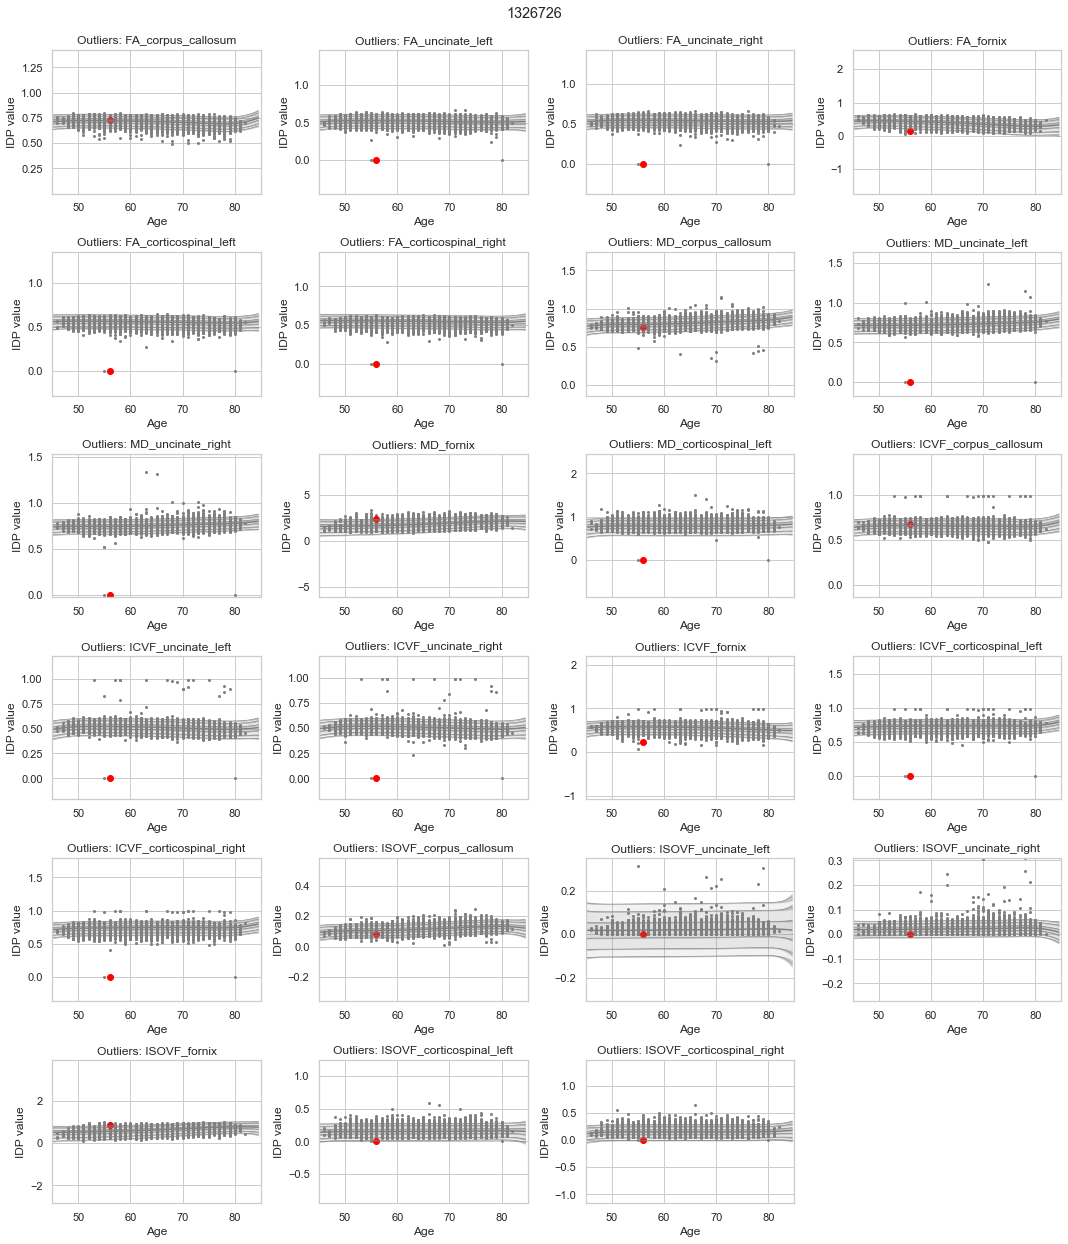

In [100]:
outlier_ID = [1326726]
df_tr_outlier = df_tr.loc[df_tr.index.isin(list_ID)]
idp_ids_short = [  'FA_corpus_callosum', 
                   'FA_uncinate_left',
                   'FA_uncinate_right',
                   'FA_fornix',
                   'FA_corticospinal_left',
                   'FA_corticospinal_right',
                   'MD_corpus_callosum', 
                   'MD_uncinate_left',
                   'MD_uncinate_right',
                   'MD_fornix',
                   'MD_corticospinal_left',               
                   'ICVF_corpus_callosum', 
                   'ICVF_uncinate_left',
                   'ICVF_uncinate_right',
                   'ICVF_fornix',
                   'ICVF_corticospinal_left',
                   'ICVF_corticospinal_right',
                   'ISOVF_corpus_callosum', 
                   'ISOVF_uncinate_left',
                   'ISOVF_uncinate_right',
                   'ISOVF_fornix',
                   'ISOVF_corticospinal_left',
                   'ISOVF_corticospinal_right']
fig1 = plt.figure(figsize=(15, 20))
for idp_num, idp in enumerate(idp_ids):
    # TRAIN DATA #
    plt.subplot(7,4,idp_num+1)
    sns.set(style='whitegrid')
    idp_dir = os.path.join(out_dir, idp)
    os.chdir(idp_dir)

    # load the true data points
    yhat_te = load_2d(os.path.join(idp_dir, 'yhat_estimate.txt'))
    s2_te = load_2d(os.path.join(idp_dir, 'ys2_estimate.txt'))
    y_te = load_2d(os.path.join(idp_dir, 'resp_te.txt'))
    idx = range(0, len(X_te))
    y_tr = load_2d(os.path.join(idp_dir, 'resp_tr.txt'))
    y_tr_outlier = df_tr_outlier[idp].to_numpy()

    # set up the covariates for the dummy data
    print('Making predictions with dummy covariates (for visualisation)')
    yhat, s2 = predict(cov_file_dummy, 
                       alg = 'blr', 
                       respfile = None, 
                       model_path = os.path.join(idp_dir,'Models'), 
                       outputsuffix = '_dummy')

    # load the normative model
    with open(os.path.join(idp_dir,'Models', 'NM_0_0_estimate.pkl'), 'rb') as handle:
        nm = pickle.load(handle) 

    # get the warp and warp parameters
    W = nm.blr.warp
    warp_param = nm.blr.hyp[1:nm.blr.warp.get_n_params()+1] 

    # first, we warp predictions for the true data and compute evaluation metrics
    med_te = W.warp_predictions(np.squeeze(yhat_te), np.squeeze(s2_te), warp_param)[0]
    med_te = med_te[:, np.newaxis]
#     print('metrics:', evaluate(y_te, med_te))

    # then, we warp dummy predictions to create the plots
    med, pr_int = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param)

    # extract the different variance components to visualise
    beta, junk1, junk2 = nm.blr._parse_hyps(nm.blr.hyp, X_dummy)
    s2n = 1/beta # variation (aleatoric uncertainty)
    s2s = s2-s2n # modelling uncertainty (epistemic uncertainty)

    # plot the (adjusted) data points
    plt.scatter(df_tr['age'], y_tr, s=4, color=clr, alpha = 1)
    plt.scatter(df_tr_outlier['age'], y_tr_outlier, color='red')
    
    # plot the median of the dummy data
    plt.plot(xx, med, clr)

    # fill the gaps in between the centiles
    junk, pr_int25 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99 = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2), warp_param, percentiles=[0.01,0.99])
    plt.fill_between(xx, pr_int25[:,0], pr_int25[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int95[:,0], pr_int95[:,1], alpha = 0.1,color=clr)
    plt.fill_between(xx, pr_int99[:,0], pr_int99[:,1], alpha = 0.1,color=clr)

    # make the width of each centile proportional to the epistemic uncertainty
    junk, pr_int25l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99l = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2-0.5*s2s), warp_param, percentiles=[0.01,0.99])
    junk, pr_int25u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.25,0.75])
    junk, pr_int95u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.05,0.95])
    junk, pr_int99u = W.warp_predictions(np.squeeze(yhat), np.squeeze(s2+0.5*s2s), warp_param, percentiles=[0.01,0.99])    
    plt.fill_between(xx, pr_int25l[:,0], pr_int25u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,0], pr_int95u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,0], pr_int99u[:,0], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int25l[:,1], pr_int25u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int95l[:,1], pr_int95u[:,1], alpha = 0.3,color=clr)
    plt.fill_between(xx, pr_int99l[:,1], pr_int99u[:,1], alpha = 0.3,color=clr)

    # plot actual centile lines
    plt.plot(xx, pr_int25[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int25[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int95[:,1],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,0],color=clr, linewidth=0.5)
    plt.plot(xx, pr_int99[:,1],color=clr, linewidth=0.5)

    plt.xlabel('Age')
    plt.ylabel('IDP value') 
    plt.title('Outliers: ' + idp_ids_short[idp_num])
    plt.xlim((45,85))
    plt.ylim((np.mean(y_te)-24*np.std(y_te)), (np.mean(y_te)+24*np.std(y_te)))
    
# fig1.tight_layout(pad = 30)
fig1.tight_layout()
plt.suptitle(str(outlier_ID[0]))
fig1.subplots_adjust(top=0.95)
plt.savefig(os.path.join('/home/preclineu/ramcir/Desktop/Diffusion/diffusion_nm/braincharts/Outliers', str(outlier_ID[0])))
plt.show()

In [72]:
y_tr_outlier

array([0.])

In [44]:
y_tr

array([[0.756112],
       [0.713533],
       [0.703294],
       ...,
       [0.729914],
       [0.675107],
       [0.702473]])

In [47]:
df_tr_outlier

eid
1326726    0.732236
Name: Mean_FA_in_body_of_corpus_callosum_on_FA_skeleton, dtype: float64